In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [53]:
class Params:
    def __init__(self,t,U,h,nu,aM0=1,n=21):
        self.t=t
        self.U=U
        self.h=h
        self.nu=nu
        self.aM0=aM0
        self.n=n
        # original lattice
        self.aM=self.aM0*np.array([[np.cos(np.deg2rad(-120)),np.sin(np.deg2rad(-120))],[np.cos(np.deg2rad(-60)),np.sin(np.deg2rad(-60))]])
        self.bM0=4*np.pi/(np.sqrt(3)*self.aM0)
        self.g=[np.array([np.cos(np.deg2rad(x)),np.sin(np.deg2rad(x))])*self.bM0 for x in np.arange(6)*60+30]
        self.bM=np.array([self.g[5],self.g[1]])
        self.neighbor_list=self._generate_neighbor()
        self._generate_ansatz()
        self._generate_k_mesh()
        self.high_symm=self._generate_high_symm()
        self.delta,self.delta_exp,self.delta_exp1234=self._generate_delta() # q1,q2,q3,q4 
        # self.o=_generate_o_matrix()
        self.sigma=_generate_pauli_matrix()
    
    def _generate_neighbor(self):
        '''
        neighbor_list: unit cell
        '''
        neighbor_list={}
        neighbor_list[0]=np.array([self.aM[0]*0])
        neighbor_list[1]=np.array([self.aM[0]*0,self.aM[0],self.aM[1]])
        # neighbor_list[1]=np.array([-1/3*(self.aM[0]+self.aM[1]),1/3*(2*self.aM[0]-self.aM[1]),1/3*(2*self.aM[1]-self.aM[0])])
        neighbor_list[2]=np.array([self.aM[0],self.aM[1],self.aM[1]-self.aM[0],-self.aM[0],-self.aM[1],-self.aM[1]+self.aM[0]])
        # neighbor_list[2]=np.array([self.aM[0],self.aM[1],self.aM[1]-self.aM[0],-self.aM[0],-self.aM[1],-self.aM[1]+self.aM[0]])
        return neighbor_list
    
    def _generate_k_mesh(self):
        R=np.array([[0,-1],[1,0]])
        self.bm_index=1/(self.ai_index).shape[0]*R.T@self.am_index@R
        self.am=self.am_index@self.aM # am_index=[[h1,h2],[k1,k2]], aM=[aM1;aM2]
        self.bm=self.bm_index@self.bM # same as above
        ux,uy=np.meshgrid(np.arange(self.n),np.arange(self.n),indexing='ij')
        kx=(2*ux.flatten(order='F')-self.n+1)/(self.n*2)
        ky=(2*uy.flatten(order='F')-self.n+1)/(self.n*2)
        self.k_index=np.column_stack((kx,ky))
        self.k=self.k_index@self.bm
        self.q=self.q_index@self.bM
        self.ai=self.ai_index@self.aM

    def _generate_high_symm(self):
        # Caveat: this is assuming the super cell is still triangular lattice
        K_=(self.bm[0]+2*self.bm[1])/3
        # Kp_=(-self.bM1+self.bM2)/3
        M_=self.bm[1]/2
        G_=0*self.bm[0]
        G_M_K_G=[G_,M_,K_,G_]
        G_M_K_G_kx,G_M_K_G_ky=_interpolate_path(G_M_K_G,self.n)
        G_M_K_G_dist=np.r_[0,np.cumsum(np.sqrt(np.diff(G_M_K_G_kx)**2+np.diff(G_M_K_G_ky)**2))]
        G_M_K_G_name={G_M_K_G_dist[idx*self.n]:n for idx,n in enumerate([r'$\Gamma$',r'M',r'$\kappa$',r'$\Gamma$'])}

        return {'kappa':K_,'M':M_,'Gamma':G_,
        'G_M_K_G':np.column_stack((G_M_K_G_kx,G_M_K_G_ky)),'G_M_K_G_dist':G_M_K_G_dist,'G_M_K_G_name':G_M_K_G_name}


    def _generate_ansatz(self):

        if self.nu==[-4,-2]:
            # Charge modulation
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            self.spinA0=[[2,0,0,0],[2,0,0,0],[2,0,0,0]]
            self.spinB0=[[0,0,0,0],[0,0,0,0],[0,0,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[-2/3,-1/3],[2/3,1/3]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
        if self.nu==[-2,-1]:
            # Charge modulation
            self.ai_index=np.array([[0,0]])
            self.spinA0=[[2,0,0,0]]
            self.spinB0=[[0,0,0,0]]
            self.am_index=np.eye(2) 
            self.q_index=np.array([[0,0]])
        
        if self.nu==[2,1]:
            self.ai_index=np.array([[0,0]])
            self.spinA0=[[1,1,0,0]]
            self.spinB0=[[1,-1,0,0]]
            self.am_index=np.eye(2) 
            self.q_index=np.array([[0,0]])
        if self.nu==[4,2]:
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
        if self.nu==[-12,-6]:
            # Intravalley s wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            self.O_max=np.array([[40,0],[0,40]])
            self.l=np.zeros((2,2))
        if self.nu==[12,6]:
            # Intravalley s wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            self.O_max=np.array([[40,0],[0,-40]])
            self.l=np.zeros((2,2))

        if self.nu==[14,7]:
            # Intervalley s wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            self.O_max=np.array([[0,40],[40,0]])
            self.l=np.zeros((2,2))

        if self.nu==[16,8]:
            # Intravalley p wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            self.O_max=np.array([[40,0],[0,-40]])
            self.l=np.ones((2,2))

        if self.nu==[18,9]:
            # Intervalley p wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            self.O_max=np.array([[0,40],[40,0]])
            self.l=np.ones((2,2))

        if self.nu==[6,3]:
            # SDW 120 Neel
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            self.spinA0=[[1,-1,0,0],[1,-np.cos(np.deg2rad(120)),-np.sin(np.deg2rad(120)),0],[1,-np.cos(np.deg2rad(240)),-np.sin(np.deg2rad(240)),0]]
            # self.spinB0=[[1,-1,0,0],[1,-np.cos(np.deg2rad(120)),-np.sin(np.deg2rad(120)),0],[1,-np.cos(np.deg2rad(240)),-np.sin(np.deg2rad(240)),0]]
            self.spinB0=[[1,0,0,0],[1,0,0,0],[1,0,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])


        if self.nu==[10,5]:
            # SDW 120 Neel
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            self.spinA0=[[1,1,0,0],[1,np.cos(np.deg2rad(120)),np.sin(np.deg2rad(120)),0],[1,np.cos(np.deg2rad(240)),np.sin(np.deg2rad(240)),0]]
            # self.spinB0=[[1,-1*.1,0,0],[1,-np.cos(np.deg2rad(120))*.1,-np.sin(np.deg2rad(120))*.1,0],[1,-np.cos(np.deg2rad(240))*.1,-np.sin(np.deg2rad(240))*.1,0]]
            self.spinB0=[[1,0,0,0],[1,0,0,0],[1,0,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])


        if self.nu==[8,4]:
            # triplet pairing
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,-1/2,0,0],[1,-1/2,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,1/2,0,0],[1,1/2,0,0]]
            self.spinB0=[[1,1,0,0],[1,np.cos(np.deg2rad(120)),np.sin(np.deg2rad(120)),0],[1,np.cos(np.deg2rad(240)),np.sin(np.deg2rad(240)),0]]
            self.spinA0=[[1,0,0,0],[1,0,0,0],[1,0,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
        
    
    def _ansatz_to_momentum(self):
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        cc=np.zeros((Nq,2,2,2,2),dtype=complex) # a,s1,s2,α1,α2
        for ai_idx,ai in enumerate(self.ai_index):
            ccA=1/2*np.sum([self.spinA0[ai_idx][i]*self.sigma[i] for i in range(4)],axis=0).conj()
            ccB=1/2*np.sum([self.spinB0[ai_idx][i]*self.sigma[i] for i in range(4)],axis=0).conj()
            cc[ai_idx,:,:,0,0]=ccA
            cc[ai_idx,:,:,1,1]=ccB
        ai_x,q1_x,q2_x=np.meshgrid(self.ai[:,0],self.q[:,0],self.q[:,0],indexing='ij')
        ai_y,q1_y,q2_y=np.meshgrid(self.ai[:,1],self.q[:,1],self.q[:,1],indexing='ij')
        exp=np.exp(1j*((q1_x-q2_x)*ai_x+(q1_y-q2_y)*ai_y)) # a,q1,q2
        ave=np.tensordot(exp, cc,axes=([0],[0])) # q1,q2,s1,s2,α1,α2
        ave=np.tile(ave[:,:,:,:,:,:,np.newaxis],[1,1,1,1,1,1,Nk])/Nq # q1,q2,s1,s2,α1,α2, k
        ave=np.transpose(ave,axes=(6,0,2,4,1,3,5)) # k,q1,s1,α1, q2,s2,α2
        return ave
    
    def _ansatz_from_order_parameter(self,O_max,l=np.zeros((2,2))):
        '''
        O is a 4 by 4 matrix defined by 
        <+K-↑ , +K+↓> <+K-↑ , -K+↓>
        <-K-↑ , +K+↓> <-K-↑ , -K+↓>
        
        '''
        theta_k=np.angle(self.k[:,0]+1j*self.k[:,1])
        norm_k=np.abs(self.k[:,0]+1j*self.k[:,1])
        exp_theta_k=np.exp(1j*theta_k)
        ave=np.zeros((self.k.shape[0],self.q.shape[0],2,2,self.q.shape[0],2,2),dtype=complex)
        k_F=np.abs(self.h/(np.sqrt(3)/2*self.t[1]*self.aM0))
        for k_idx in range(ave.shape[0]):
            O=O_max* np.exp(-(norm_k[k_idx]-k_F)**2/(2*(k_F/4)**2))*np.exp(1j*l*theta_k[k_idx])
            # O=O_max*np.exp(1j*l*theta_k[k_idx])
            OO=np.array(
                [[O[0,0]/2, O[0,0]*exp_theta_k[k_idx]/2, -O[0,1]*exp_theta_k[k_idx]/2, O[0,1]/2],
                [-O[0,0]*exp_theta_k[k_idx].conj()/2,  -O[0,0]/2,  O[0,1]/2,  -O[0,1]*exp_theta_k[k_idx].conj()/2],
                [O[1,0]*exp_theta_k[k_idx].conj()/2,  O[1,0]/2,  -O[1,1]/2,  O[1,1]*exp_theta_k[k_idx].conj()/2],
                [O[1,0]/2,  O[1,0]*exp_theta_k[k_idx]/2,  -O[1,1]*exp_theta_k[k_idx]/2,  O[1,1]/2]])
            for s in range(2):
                # s=0 ↑, s=1 ↓
                OO_tmp=OO.conj().T if s == 1 else OO
                ave[k_idx,1,s,:,1,1-s,:]=OO_tmp[:2,:2] # +K,+K
                ave[k_idx,1,s,:,2,1-s,:]=OO_tmp[:2,2:] # +K,-K
                ave[k_idx,2,s,:,1,1-s,:]=OO_tmp[2:,:2] # -K,+K
                ave[k_idx,2,s,:,2,1-s,:]=OO_tmp[2:,2:] # -K,-K
        return ave
            

    def energy_MF(self,ave):
        T=self._generate_T(self.k)
        H_H=self._generate_Hartree(ave)
        H_F=self._generate_Fock(ave)
        H=T+H_H+H_F
        energyall,wfall=self._eig(H)
        return energyall,wfall

    def iteration(self,print_opt='o',thres=1e-5):
        ave=self._ansatz_to_momentum() if not hasattr(self, 'O_max') else self._ansatz_from_order_parameter(self.O_max,self.l)
        gap_list=[]
        spin_list=[]
        energy_list=[]
        gap_list.append(np.nan)
        energy_list.append(np.nan)
        spin_list.append(self.print_spin(ave,print_opt))
        for i in range(20):
            energyall,wfall=self.energy_MF(ave)
            ave=self._average(energyall, wfall)
            print(f'Iteration {i}:\t',end=None)
            gap_list.append(self.print_gap(energyall))
            energy_list.append(self.total_energy(ave))
            spin_list.append(self.print_spin(ave,print_opt))
            if i>2 and np.abs(energy_list[-1]-energy_list[-2])<thres:
                break

        return np.array(gap_list),np.array(energy_list),np.array(spin_list),ave
        
    def _eig(self,H):
        herr=np.abs(H-H.transpose((1,0,2)).conj()).max()
        assert herr<1e-12, f'hermittian error:{herr}'
        H=1/2*(H+H.transpose((1,0,2)).conj())
        Nk=H.shape[-1]
        Nq=self.q.shape[0]
        energyall=np.zeros((Nk,Nq*4),dtype=float)   # k, l
        wfall=np.zeros((Nk,Nq*4,Nq*4),dtype=complex)    #k,l,l
        for k_idx in range(Nk):
            H0=H[:,:,k_idx]
            val,vec=np.linalg.eigh(H0)
            order=np.argsort(val)
            vec=vec[:,order]
            val=val[order]
            energyall[k_idx]=val
            wfall[k_idx]=vec.T
        return energyall,wfall



    
    def _generate_T(self,k_list):
        Nq,Nk=self.q.shape[0],k_list.shape[0]
        T=np.zeros((2*2*Nq,2*2*Nq,Nk),dtype=complex)
        for k_idx,k in enumerate(k_list):
            T0=np.zeros((2*2*Nq,2*2*Nq),dtype=complex)
            for q_idx,q in enumerate(self.q):
                gamma1=np.sum(np.exp(1j*self.neighbor_list[1]@(q+k)))
                gamma2=np.sum(np.exp(1j*self.neighbor_list[2]@(q+k)))
                H_up=np.array([[self.t[0]+self.t[2]*gamma2+self.h, self.t[1]*gamma1 ],
                               [self.t[1]*gamma1.conj(), self.t[0]+self.t[2]*gamma2+self.h]])
                H_down=np.array([[self.t[0]+self.t[2]*gamma2-self.h, self.t[1]*gamma1 ],
                               [self.t[1]*gamma1.conj(), self.t[0]+self.t[2]*gamma2-self.h]])
                T0[4*q_idx:4*q_idx+2,4*q_idx:4*q_idx+2]=H_up
                T0[4*q_idx+2:4*q_idx+4,4*q_idx+2:4*q_idx+4]=H_down
            T[:,:,k_idx]=T0
        return T

    def _generate_delta(self,thres=1e-10):
        q1_index_1,q2_index_1,q3_index_1,q4_index_1=np.meshgrid(self.q_index[:,0],self.q_index[:,0],self.q_index[:,0],self.q_index[:,0],indexing='ij')
        q1_index_2,q2_index_2,q3_index_2,q4_index_2=np.meshgrid(self.q_index[:,1],self.q_index[:,1],self.q_index[:,1],self.q_index[:,1],indexing='ij')
        delta_1=q1_index_1-q2_index_1+q3_index_1-q4_index_1
        delta_2=q1_index_2-q2_index_2+q3_index_2-q4_index_2
        delta=((np.abs(delta_1%1)<thres) & (np.abs(delta_2%1)<thres)).astype('int8') # q1,q2,q3,q4

        q3_x,q4_x,n_x=np.meshgrid(self.q[:,0],self.q[:,0],self.neighbor_list[1][:,0],indexing='ij')
        q3_y,q4_y,n_y=np.meshgrid(self.q[:,1],self.q[:,1],self.neighbor_list[1][:,1],indexing='ij')
        exp=np.sum(np.exp(-1j*((q3_x-q4_x)*n_x+(q3_y-q4_y)*n_y)),axis=-1) # q3,q4
        delta_exp=delta*exp[np.newaxis,np.newaxis,:,:] # q1,q2,q3,q4

        k_x,kp_x,q1_x,q2_x,q3_x,q4_x,n_x = np.meshgrid(self.k[:,0],self.k[:,0],self.q[:,0],self.q[:,0],self.q[:,0],self.q[:,0],self.neighbor_list[1][:,0],indexing='ij' )
        k_y,kp_y,q1_y,q2_y,q3_y,q4_y,n_y = np.meshgrid(self.k[:,1],self.k[:,1],self.q[:,1],self.q[:,1],self.q[:,1],self.q[:,1],self.neighbor_list[1][:,1],indexing='ij' )
        exp14=np.sum(np.exp(-1j*((q1_x-q4_x+k_x-kp_x)*n_x + (q1_y-q4_y+k_y-kp_y)*n_y)),axis=-1) # k,k',q1,q2,q3,q4
        exp32=np.sum(np.exp(-1j*((q3_x-q2_x+kp_x-k_x)*n_x + (q3_y-q2_y+kp_y-k_y)*n_y)),axis=-1) # k,k',q1,q2,q3,q4
        exp1234=np.stack([exp14,exp32],axis=-1) # k,k',q1,q2,q3,q4, α1
        delta_exp1234=delta[np.newaxis,np.newaxis,:,:,:,:,np.newaxis]*exp1234

        return delta,delta_exp,delta_exp1234
    
    def _generate_Hartree(self,ave):
        '''
        ave k',q3,s3,α3, q4,s4,α4
        '''
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        N=Nq*Nk

        # ave_T=np.transpose(ave,axes=[6,0,2,4,1,3,5]) # k,q3,s3,α3, q4,s4,α4
            
        ave_k=np.sum(ave,axis=0)   #q3,s3,α3,q4,s4,α4
        delta_ave=np.tensordot(self.delta, ave_k,axes=([2,3],[0,3]))  # q1,q2,s3,α3,s4,α4
        delta=np.tensordot(np.tensordot(np.tensordot(self.sigma[1],self.sigma[0],axes=0),self.sigma[1],axes=0),self.sigma[0],axes=0) # s3,s1,α3,α1,s4,s2,α4,α2
        delta_ave_delta=np.tensordot(delta_ave,delta,axes=([2,3,4,5],[0,2,4,6])) # q1,q2,s1,α1,s2,α2
        
        delta_ave_delta=delta_ave_delta*self.sigma[0][np.newaxis,np.newaxis,:,np.newaxis,:,np.newaxis]*self.sigma[0][np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,:]
        delta_ave_delta=np.transpose(delta_ave_delta,axes=(0,2,3,1,4,5)) # q1,s1,α1,q2,s2,α2
        H_H_0=delta_ave_delta.reshape((Nq*4,Nq*4))*self.U[0]/(N)



        
        delta=np.tensordot(np.tensordot(self.sigma[0],self.sigma[1],axes=0),self.sigma[1],axes=0) # s3,s4,α3,α1,α4,α2
        delta_ave=np.tensordot(self.delta_exp, ave_k,axes=([2,3],[0,3]))  # q1,q2,s3,α3,s4,α4
        delta_ave_delta_1=np.tensordot(delta_ave,delta,axes=([2,3,4,5],[0,2,1,4])) # q1,q2,α1,α2
        # delta_ave_delta_1=delta_ave_delta_1*self.sigma[0][np.newaxis,np.newaxis,:,np.newaxis,:,np.newaxis]*self.sigma[0][np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,:]
        delta_ave_delta_1=np.tensordot(delta_ave_delta_1*self.sigma[0][np.newaxis,np.newaxis,:,:],self.sigma[0],axes=0) # q1,q2,α1,α2,s1,s2
        delta_ave_delta_1=np.transpose(delta_ave_delta_1,axes=(0,4,2,1,5,3)) # q1,s1,α1,q2,s2,α2
        H_H_1=delta_ave_delta_1.reshape((Nq*4,Nq*4))*self.U[1]/(N)
        
        H_H=H_H_0+H_H_1
        return np.tile(H_H[:,:,np.newaxis],[1,1,Nk])

    
        

    def _generate_Fock(self,ave):
        '''
        ave k',q3,s3,α3, q4,s4,α4
        '''
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        N=Nq*Nk


        # ave_T=np.transpose(ave,axes=[6,0,2,4,1,3,5]) # k,q3,s3,α3, q4,s4,α4
        ave_k=np.sum(ave,axis=0)   #q3,s3,α3,q4,s4,α4
        delta_ave=np.tensordot(self.delta, ave_k,axes=([2,3],[0,3]))  # q1,q2,s3,α3,s4,α4
        delta=np.tensordot(np.tensordot(np.tensordot(self.sigma[0],self.sigma[0],axes=0),self.sigma[0],axes=0),self.sigma[0],axes=0) # s3,s2,α3,α1,s4,s1,α4,α2
        delta_ave_delta=np.tensordot(delta_ave,delta,axes=([2,3,4,5],[0,2,4,6])) # q1,q2,s2,α1,s1,α2
        delta_ave_delta=delta_ave_delta*self.sigma[1][np.newaxis,np.newaxis,:,np.newaxis,:,np.newaxis]*self.sigma[0][np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,:]
        delta_ave_delta=np.transpose(delta_ave_delta,axes=(0,4,3,1,2,5)) # q1,s1,α1,q2,s2,α2
        H_F_0=-delta_ave_delta.reshape((Nq*4,Nq*4))*self.U[0]/(N)

        

        # delta s3,s2,α3,α2,s4,s1,α4,α1
        # delta_exp1234 k,k',q1,q2,q3,q4, α1
        delta_T=np.transpose(delta,axes=(7,3,2,6,5,1,0,4)) # α1,α2,α3,α4,s1,s2,s3,s4
        delta2=delta_T*self.sigma[1][:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis] # α1,α2,α3,α4,s1,s2,s3,s4
        delta3=self.delta_exp1234[:,:,:,:,:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis] * delta2[np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis,:,:,:,:,:,:,:,:] #k,k',q1,q2,q3,q4,α1,α2,α3,α4,s1,s2,s3,s4
        delta3_ave=np.tensordot(delta3,ave,axes=([1,4,12,8,5,13,9],[0,1,2,3,4,5,6])) # k,q1,q2,α1,α2,s1,s2
        delta3_ave_T=np.transpose(delta3_ave,axes=(1,5,3,2,6,4,0)) # q1,s1,α1,q2,s2,α2,k
        H_F_1=-delta3_ave_T.reshape((Nq*4,Nq*4,Nk))*self.U[1]/(N) # (q1,s1,α1),(q2,s2,α2),k

        # delta_ave=np.tensordot(self.delta_exp, ave_k,axes=([2,3],[0,3]))  # q1,q2,s3,α3,s4,α4
        # delta_ave_delta_1=np.tensordot(delta_ave,delta,axes=([2,3,4,5],[0,2,4,6])) # q1,q2,s2,α2,s1,α1
        # delta_ave_delta_1=delta_ave_delta_1*self.sigma[1][np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,:]
        # delta_ave_delta_1=np.transpose(delta_ave_delta_1,axes=(0,4,5,1,2,3)) # q1,s1,α1,q2,s2,α2
        # H_F_1=-delta_ave_delta.reshape((Nq*4,Nq*4))*self.U[1]/(N)

        H_F=H_F_0[:,:,np.newaxis]+H_F_1

        # return np.tile(H_F[:,:,np.newaxis],[1,1,Nk])
        return H_F
        
    
    
    def _average(self,energyall,wfall):
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        N=Nq*Nk
        energyall_sort=np.sort(energyall.flatten())
        mu=energyall_sort[Nq*Nk*self.nu[0]//self.nu[1]-1] # !!Need check
        occ=(energyall<=mu)  # k2,l
        c=wfall.reshape((Nk,4*Nq,Nq,2,2))   # c_{k2,l,q2,s2,α2}
        c_conj=c.conj()  # c_{k1,l,q1,s1,α1}
        c_occ=c*occ[:,:,np.newaxis,np.newaxis,np.newaxis] # {k2,l,q2,s2,α2}
        cc_c_occ=np.tensordot(c_conj,c_occ,axes=([1],[1])) # k1,q1,s1,α1, k2 ,q2,s2,α2
        deltakk=np.eye(self.k.shape[0])
        ave=np.sum(cc_c_occ*deltakk[:,np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,np.newaxis,np.newaxis],axis=4) # k1,q1,s1,α1,q2,s2,α2
        return ave




    def total_energy(self,ave):
        '''
        total average energy per unit cell
        '''
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        N=Nq*Nk
        # Kinetic
        T=self._generate_T(self.k) # This is redundant, change it to self.T
        T=np.transpose(T,axes=(2,0,1))
        T=T.reshape((Nk,Nq,2,2,Nq,2,2)) # k,q1,s1,α1,q2,s2,α2
        H_0=np.tensordot(ave, T,axes=([0,1,2,3,4,5,6],[0,1,2,3,4,5,6]))

        # Hatree 0
        delta=np.tensordot(self.sigma[0],self.sigma[0],axes=0)*self.sigma[0][:,np.newaxis,:,np.newaxis] #  δ_{α1,α2} ⊗  δ_{α3,α4}  * δ_{α1,α3} = δ_{α1,α2,α3,α4}
        ave_uu=ave[:,:,0,:,:,0,:].sum(axis=0) # q1,α1,q2,α2
        ave_dd=ave[:,:,1,:,:,1,:].sum(axis=0) # q3,α3,q4,α4
        ave_dd_delta=np.tensordot(ave_dd,delta,axes=([1,3],[2,3])) # q3,q4,α1,α2
        ave_uu_ave_dd_delta=np.tensordot(ave_uu,ave_dd_delta,axes=([1,3],[2,3])) # q1,q2,q3,q4
        delta_ave_uu_ave_dd_delta=np.tensordot(self.delta, ave_uu_ave_dd_delta,axes=([0,1,2,3],[0,1,2,3]))

        H_H_0=delta_ave_uu_ave_dd_delta*self.U[0]/N

        # Fock 0
        ave_du=ave[:,:,1,:,:,0,:].sum(axis=0) # q1,α1,q2,α2
        ave_ud=ave[:,:,0,:,:,1,:].sum(axis=0) # q3,α3,q4,α4
        ave_ud_delta=np.tensordot(ave_ud,delta,axes=([1,3],[2,3])) # q3,q4,α1,α2
        ave_du_ave_ud_delta=np.tensordot(ave_du,ave_ud_delta,axes=([1,3],[2,3])) # q1,q2,q3,q4
        delta_ave_du_ave_du_delta=np.tensordot(self.delta, ave_du_ave_ud_delta,axes=([0,1,2,3],[0,1,2,3]))
        H_F_0=-delta_ave_du_ave_du_delta*self.U[0]/N

        # Hartree 1
        ave_AA=ave[:,:,:,0,:,:,0].sum(axis=(0,2,4)) # q1,q2
        ave_BB=ave[:,:,:,1,:,:,1].sum(axis=(0,2,4)) # q3,q4
        delta_ave_AA=np.tensordot(self.delta_exp, ave_AA,axes=([0,1],[0,1])) # q3,q4
        delta_ave_AA_ave_BB=np.tensordot(delta_ave_AA,ave_BB,axes=([0,1],[0,1])) 
        H_H_1=delta_ave_AA_ave_BB*self.U[1]/N

        # Fock 1
        ave_AB=ave[:,:,:,0,:,:,1].sum(axis=0) # q1,s',q2,s
        ave_BA=ave[:,:,:,1,:,:,0].sum(axis=0) # q3,s,q4,s'
        ave_ave=np.tensordot(ave_AB,ave_BA,axes=([1,3],[3,1])) # q1,q2,q3,q4
        delta_ave_ave=np.tensordot(self.delta_exp,ave_ave,axes=([0,1,2,3],[0,1,2,3]))
        H_F_1=-delta_ave_ave*self.U[1]/N

        H_tot=H_0+H_H_0+H_H_1+H_F_0+H_F_1
        assert np.abs(H_tot.imag)<1e-10, f"total energy is not real {H_tot}"
        H_tot=H_tot.real/N
        print(f'E(meV):{H_tot}')
        return H_tot

    def print_gap(self,energyall):
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        energyall_sort=np.sort(energyall.flatten())
        mu_v=energyall_sort[Nq*Nk*self.nu[0]//self.nu[1]-1]
        mu_c=energyall_sort[Nq*Nk*self.nu[0]//self.nu[1]]
        gap=mu_c-mu_v
        print(f'Gap(meV)={gap}')
        return gap

    
    def _generate_spin_mat(self,ave):
        '''
        convert from ave (k1,q1,s1,α1,q2,s2,α2) to ave_exp (α1,α2,a1,a2) for each sigma matrix
        '''
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        N=Nq*Nk
        k_x,q1_x,a1_x,q2_x,a2_x=np.meshgrid(self.k[:,0],self.q[:,0],self.ai[:,0],self.q[:,0],self.ai[:,0],indexing='ij')
        k_y,q1_y,a1_y,q2_y,a2_y=np.meshgrid(self.k[:,1],self.q[:,1],self.ai[:,1],self.q[:,1],self.ai[:,1],indexing='ij')
        exp=np.exp(-1j*(a1_x*(q1_x+k_x)+a1_y*(q1_y+k_y))+1j*(a2_x*(q2_x+k_x)+a2_y*(q2_y+k_y))) # k1,q1,a1,q2,a2
        spin_mat=np.zeros((4,2,2,Nq,Nq),dtype=complex)
        for sigma_idx,sigma in enumerate(self.sigma):
            ave_sigma=np.tensordot(ave,sigma,axes=([2,5],[0,1])) # k,q1,α1,q2,α2
            spin_mat[sigma_idx]=np.tensordot(ave_sigma,exp,axes=([0,1,3],[0,1,3]))/N # α1,α2,a1,a2
        return spin_mat

    def print_spin(self,ave,output='o'):
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        spin_mat=self._generate_spin_mat(ave)
        # delta_aa=np.eye(Nq)
        # if output=='onsite':

        spin_list=np.zeros((4,2*Nq))

        for spin_idx,spin in enumerate(spin_mat):
            spin_texture=np.transpose(spin,axes=(0,2,1,3)).reshape((2*Nq,2*Nq))
            if 'o' in output:
                # onsite
                spin_diag=np.diag(spin_texture)
                assert np.abs(spin_diag.imag).max()<1e-10, f"spin is not real for {spin_idx} with {spin_diag}"
                spin_str=' '.join([f'{spin:.3f}' for spin in spin_diag.real])
                print(f'S{spin_idx}: {spin_str}')
                spin_list[spin_idx]=spin_diag.real
            if 'b' in output:
                # bond
                i,j=np.triu_indices(n=spin_texture.shape[0], k=1)
                spin_triu=spin_texture[i,j].flatten()
                spin_str=' '.join([f'{spin:.3f}' for spin in spin_triu])

                print(f'S{spin_idx}_b: {spin_str}')
                
        return spin_list.T





    def plot_dispersion(self,ax=None,k=100,line='G_M_K_G',color='k'):
        '''
        take 100 maximal band
        '''
        assert line in {'G_M_K_G','K_M_Kp_G'}, 'line should be "K_M_Kp_G" or "G_M_K_G"'
        T=self._generate_T(self.high_symm[line])
        energy_list,wfall=self._eig(T)

        if ax is not False:
            if ax is None:
                # fig,ax=plt.subplots(figsize=(4,4/self.am[0,0]*self.am[1,1]))
                fig,ax=plt.subplots()
            ax.plot(self.high_symm[line+'_dist'],energy_list[:,:k],color=color)

            xticks,xticklabels=[],[]
            for pos,name in self.high_symm[line+'_name'].items():
                ax.axvline(x=pos,ls='dashed',color='k',lw=1)
                xticks.append(pos)
                xticklabels.append(name)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)

            ax.set_ylabel(r'$E$ (meV)')
            ax.set_xlim(self.high_symm[line+'_dist'][[0,-1]])
            # ax.set_ylim(energy_list[:,k].min(),energy_list[:,0].max()) 

        return energy_list
    
def _interpolate_path(path,n):
    '''
    path: directional path
    n: # of pts 
    '''
    k=np.arange(n)/n 
    
    return np.hstack([(1-k)*start[0]+k*end[0] for start,end in zip(path[:-1],path[1:])]+[path[-1][0]]),np.hstack([(1-k)*start[1]+k*end[1] for start,end in zip(path[:-1],path[1:])]+[path[-1][1]])


def _generate_o_matrix():
    o=np.zeros((4,4,4,4))
    for i in range(4):
        for j in range(4):
            o[i,j,i,j]=1
    return o

def _generate_pauli_matrix():
    sigma0=np.eye(2)
    sigmax=np.array([[0,1],[1,0]])
    sigmay=np.array([[0,-1j],[1j,0]])
    sigmaz=np.array([[1,0],[0,-1]])
    return [sigma0,sigmax,sigmay,sigmaz]

In [48]:
# params=Params(t=[0,0,0],U=[1,4],h=.6,nu=[2,1],n=15)
params=Params(t=[0,-1,0],U=[1,0],h=.2,nu=[4,2],n=15)


In [49]:
ave=params._ansatz_from_order_parameter(np.array([[40,0],[0,40]]),l=np.zeros((2,2)))
# ave=params._ansatz_from_order_parameter(np.array([[0,1j*40],[1j*40,0]]),l=np.zeros((2,2)))
# ave=params._ansatz_from_order_parameter(np.array([[40,0],[0,-40]]),l=np.ones((2,2)))
# ave=params._ansatz_from_order_parameter(np.array([[0,40],[40,0]]),l=np.ones((2,2)))

In [44]:
ave.max()

(19.64673963846937+0j)

In [51]:
spin_mat=params._generate_spin_mat(ave)

In [24]:
-0.3842*np.sin(np.deg2rad(120))

-0.33272696013398134

In [52]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,0.0000+0.0000j,0.0000-0.4256j,-0.0000+0.4008j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
A2,0.0000+0.4256j,0.0000+0.0000j,0.0000-0.4256j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
A3,-0.0000-0.4008j,0.0000+0.4256j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
B1,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,-0.0000+0.0000j,-0.0000+0.4256j,0.0000-0.4008j
B2,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,-0.0000-0.4256j,-0.0000+0.0000j,-0.0000+0.4256j
B3,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.4008j,-0.0000-0.4256j,-0.0000+0.0000j


In [47]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),3),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,0.000+0.000j,0.000+0.000j,0.000+0.000j,-0.000-0.000j,-0.178+0.000j,0.639+0.000j
A2,0.000+0.000j,0.000+0.000j,0.000+0.000j,-0.356+0.000j,-0.000-0.000j,-0.178+0.000j
A3,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.320+0.000j,-0.356+0.000j,-0.000-0.000j
B1,-0.000+0.000j,-0.356-0.000j,0.320-0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j
B2,-0.178-0.000j,-0.000+0.000j,-0.356-0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j
B3,0.639-0.000j,-0.178-0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j


In [ ]:
s1,s2=0,1
a1,a2=0,0
di=1
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].real.min(),ave[:,:,s1,a1,:,s2,a2].real.max()
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+di)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
plt.colorbar()
plt.scatter(*params.q.T,color='r',s=1)
plt.axis('equal')

In [ ]:
s1,s2=0,1
a1,a2=0,0
di=1
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].imag.min(),ave[:,:,s1,a1,:,s2,a2].imag.max()
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+di)%3,s1,a1,i,s2,a2].imag,vmin=vmin,vmax=vmax)
plt.colorbar()
plt.scatter(*params.q.T,color='r',s=1)
plt.axis('equal')

In [95]:
0.184*np.exp(1j*2*np.pi/3)

(-0.09199999999999996+0.15934867429633673j)

In [238]:
ave.shape

(1089, 3, 2, 2, 3, 2, 2)

In [136]:
params.print_spin(ave)

array([[ 0.     ,  0.41027,  0.     ,  0.     ],
       [ 0.     , -0.20514,  0.22204,  0.     ],
       [ 0.     , -0.20514, -0.22204,  0.     ],
       [ 0.     , -0.41027, -0.     ,  0.     ],
       [ 0.     ,  0.20514,  0.22204,  0.     ],
       [ 0.     ,  0.20514, -0.22204,  0.     ]])

In [40]:
params.q

array([[ 0.00000000e+00,  0.00000000e+00],
       [-4.18879020e+00,  2.20666443e-15],
       [ 4.18879020e+00, -2.20666443e-15]])

(-6.757914863722042, 6.757914863722042, -3.7243346945609295, 9.791495032883155)

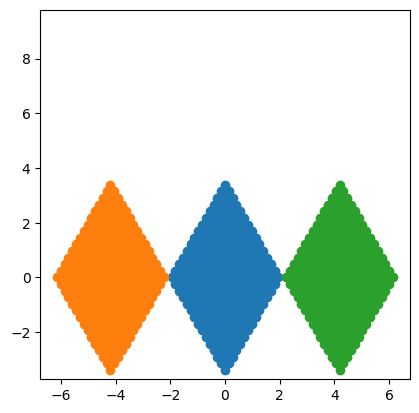

In [52]:
plt.scatter(params.k[:,0],params.k[:,1])
plt.scatter(params.k[:,0]+params.q[1,0],params.k[:,1]+params.q[1,1])
plt.scatter(params.k[:,0]+params.q[2,0],params.k[:,1]+params.q[2,1])
plt.axis('square')

In [15]:
z=np.arange(24).reshape((2,3,4))

In [17]:
z[0,0,2]

2

In [21]:
np.arange(6)*60+30

array([ 30,  90, 150, 210, 270, 330])

In [19]:
params.g

[array([7.25519746, 0.        ]),
 array([3.62759873, 6.28318531]),
 array([-3.62759873,  6.28318531]),
 array([-7.25519746e+00,  8.88505434e-16]),
 array([-3.62759873, -6.28318531]),
 array([ 3.62759873, -6.28318531])]

In [30]:
params.g

[array([6.28318531, 3.62759873]),
 array([4.44252717e-16, 7.25519746e+00]),
 array([-6.28318531,  3.62759873]),
 array([-6.28318531, -3.62759873]),
 array([-1.33275815e-15, -7.25519746e+00]),
 array([ 6.28318531, -3.62759873])]

In [31]:
params.bM


array([[ 6.28318531e+00, -3.62759873e+00],
       [ 4.44252717e-16,  7.25519746e+00]])

In [9]:
np.angle(params.k[:,0]+1j*params.k[:,1])

array([-0.52359878, -0.56385726, -0.60589112, ...,  2.53570153,
        2.57773539,  2.61799388])

(-2.2340214425527414, 5.504855844846588, -3.869438643699665, 3.869438643699665)

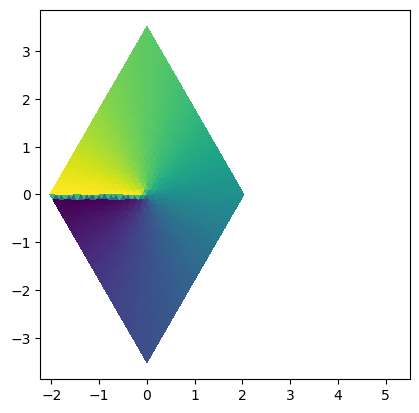

In [66]:
plt.tripcolor(params.k[:,0],params.k[:,1],np.angle(params.k[:,0]+1j*params.k[:,1]))
plt.axis('square')

In [68]:
params.q

array([[ 0.00000000e+00,  0.00000000e+00],
       [-4.18879020e+00,  2.20666443e-15],
       [ 4.18879020e+00, -2.20666443e-15]])

(-2.2340214425527414, 5.504855844846588, -3.869438643699665, 3.869438643699665)

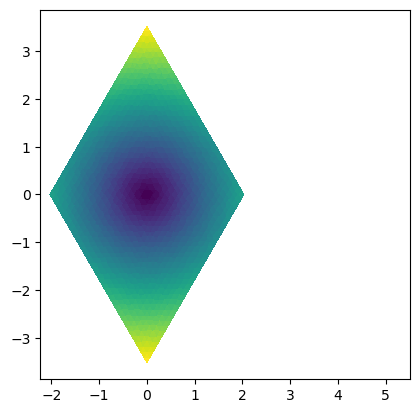

In [67]:
plt.tripcolor(params.k[:,0],params.k[:,1],np.abs(params.k[:,0]+1j*params.k[:,1]))
plt.axis('square')

In [56]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-7)

S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 1.000 1.000 1.000 -1.000 -1.000 -1.000
S2: 0.000 0.000 0.000 0.000 0.000 0.000
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=1.0000145262158604
E(meV):-2.5583070398935255
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.370 0.370 0.370 -0.370 -0.370 -0.370
S2: -0.000 0.000 -0.000 -0.000 -0.000 -0.000
S3: -0.053 -0.053 -0.053 -0.053 -0.053 -0.053
Iteration 1:	
Gap(meV)=0.3716980695844764
E(meV):-2.6376566112101654
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.169 0.169 0.169 -0.169 -0.169 -0.169
S2: -0.000 0.000 0.000 0.000 -0.000 -0.000
S3: -0.032 -0.032 -0.032 -0.032 -0.032 -0.032
Iteration 2:	
Gap(meV)=0.16983803053615582
E(meV):-2.6494931576796072
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.086 0.086 0.086 -0.086 -0.086 -0.086
S2: 0.000 -0.000 -0.000 -0.000 -0.000 -0.000
S3: -0.022 -0.022 -0.022 -0.022 -0.022 -0.022
Iteration 3:	
Gap(meV)=0.08588944520208547
E(meV):-2.6518704888511713
S0: 1.000 1.000 1.000 1.000 1.000 1.000

(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

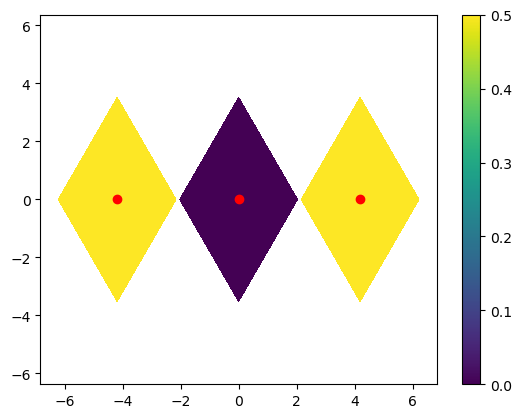

In [96]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+0)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [ ]:
[Gamma, K, K']
[ K', Gamma, K]


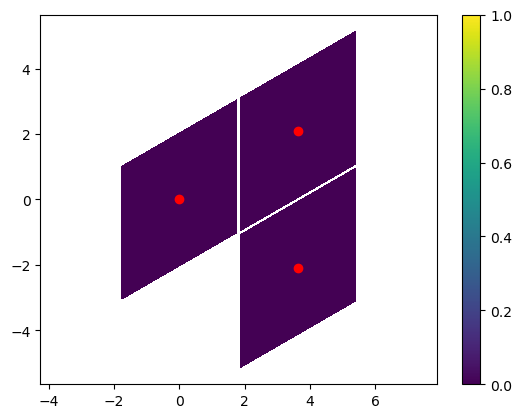

In [246]:
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,i,0,0,(i+1)%3,0,0].real,vmin=0,vmax=.1)
plt.scatter(*params.q.T,color='r')
plt.axis('equal')
plt.colorbar()

In [38]:
params.bm

array([[-3.62759873e+00, -2.09439510e+00],
       [ 8.09056761e-17,  4.18879020e+00]])

(-3.99035860131528, 9.83264907447981, -6.911503837897545, 6.911503837897545)

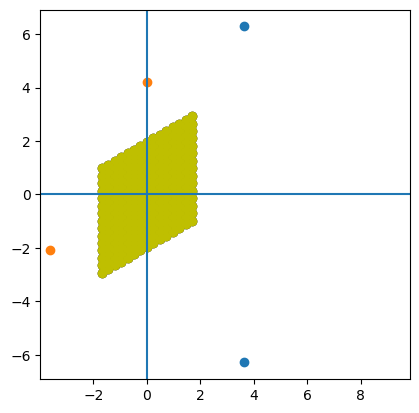

In [52]:
plt.scatter(*params.bM.T)
plt.scatter(*params.bm.T)
plt.scatter(*params.k.T,color='k')
plt.scatter(*shift_to_FBZ(params.k,params.bm).T,color='y')
plt.axvline(x=0)
plt.axhline(y=0)

plt.axis('square')

In [53]:
shift_to_FBZ(params.k,params.bm)-params.k

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

In [260]:
3*params.U[1]-2*params.h # Energy

10.8

In [261]:
params.U[0]+2*params.h # Gap

2.2

Text(0, 0.5, '$S_{x,y,z}$')

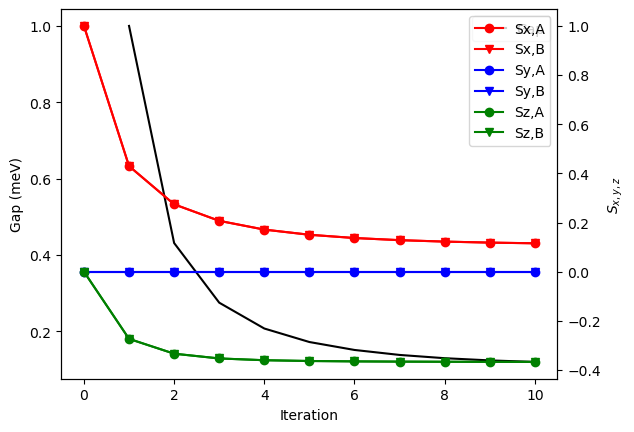

In [319]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k',label='Gap')
ax.legend()
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

Text(0, 0.5, 'Energy')

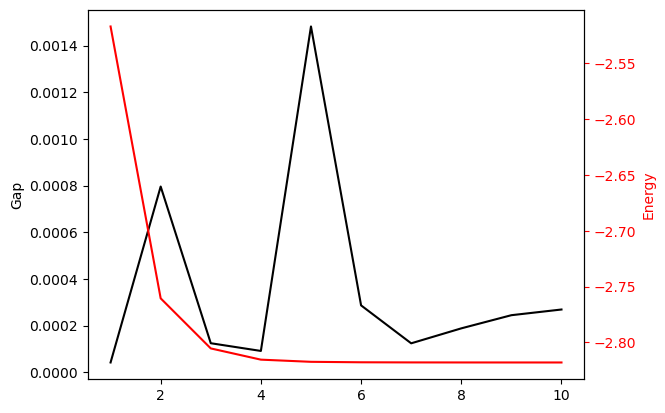

In [328]:
fig,ax=plt.subplots()
ax.plot(gap_list,color='k',label='Gap')
ax.set_ylabel('Gap')
ax2=ax.twinx()
ax2.plot(energy_list,color='r',label='Energy')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel('Energy',color='red')

In [331]:
params=Params(t=[0,1,0.],U=[1,.8],h=0.1,nu=[-2,-1],n=15)
# params=Params(t=[0,0,0.],U=[1,.8],h=0.1,nu=[-4,-2],n=15)

In [268]:
6*params.U[1]-params.U[0]-2*params.h

3.6000000000000005

In [332]:
gap_list,energy_list,spin_list=params.iteration(print_opt='o')

S0: 2.00 0.00
S1: 0.00 0.00
S2: 0.00 0.00
S3: 0.00 0.00
Iteration 0:	
Gap(meV)=3.6
E(meV):-0.6504228526971246
S0: 1.77 0.23
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 1:	
Gap(meV)=2.74241447226947
E(meV):-0.7660270358587831
S0: 1.70 0.30
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 2:	
Gap(meV)=2.460222336731322
E(meV):-0.8009410281787968
S0: 1.67 0.33
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 3:	
Gap(meV)=2.3404688142077603
E(meV):-0.8149403816433257
S0: 1.65 0.35
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 4:	
Gap(meV)=2.2845957435345206
E(meV):-0.8212735835070377
S0: 1.65 0.35
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 5:	
Gap(meV)=2.257403775652284
E(meV):-0.8243066305484883
S0: 1.64 0.36
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 6:	
Gap(meV)=2.243901305085436
E(meV):-0.825800350069615
S0: 1.64 0.36
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 7:	
Gap(meV)=2.2371298725166073
E(meV):-0.8265463011550556
S0: 1.64 0.36


In [ ]:
gap_list,energy_list,spin_list=params.iteration(print_opt='o')

S0: 2.00 0.00
S1: 0.00 0.00
S2: 0.00 0.00
S3: 0.00 0.00
Iteration 0:	
Gap(meV)=3.6
E(meV):-0.6504228526971246
S0: 1.77 0.23
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 1:	
Gap(meV)=2.74241447226947
E(meV):-0.7660270358587831
S0: 1.70 0.30
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 2:	
Gap(meV)=2.460222336731322
E(meV):-0.8009410281787968
S0: 1.67 0.33
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 3:	
Gap(meV)=2.3404688142077603
E(meV):-0.8149403816433257
S0: 1.65 0.35
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 4:	
Gap(meV)=2.2845957435345206
E(meV):-0.8212735835070377
S0: 1.65 0.35
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 5:	
Gap(meV)=2.257403775652284
E(meV):-0.8243066305484883
S0: 1.64 0.36
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 6:	
Gap(meV)=2.243901305085436
E(meV):-0.825800350069615
S0: 1.64 0.36
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 7:	
Gap(meV)=2.2371298725166073
E(meV):-0.8265463011550556
S0: 1.64 0.36


Text(0, 0.5, '$S_{x,y,z}$')

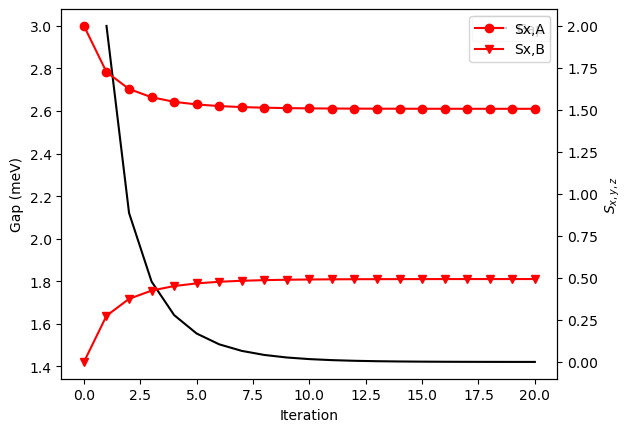

In [90]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k',label='Gap')
ax.legend()
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,0],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,0],"v-",label='Sx,B',color='red')
# ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
# ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
# ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
# ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
# ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
# ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

Text(0, 0.5, 'Energy')

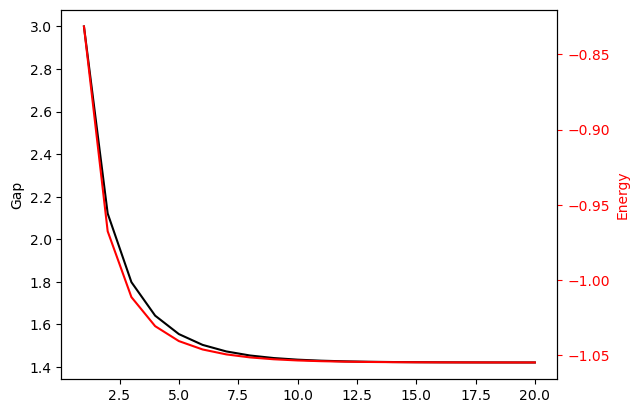

In [91]:
fig,ax=plt.subplots()
ax.plot(gap_list,color='k',label='Gap')
ax.set_ylabel('Gap')
ax2=ax.twinx()
ax2.plot(energy_list,color='r',label='Energy')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel('Energy',color='red')

# p-wave SDW

In [404]:
params=Params(t=[0,-1,-.2],U=[4,0],h=.2,nu=[10,5],n=27)

In [405]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-8)

S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 1.000 -0.500 -0.500 0.000 0.000 0.000
S2: 0.000 0.866 -0.866 0.000 0.000 0.000
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=1.3322676295501878e-15
E(meV):-1.01068874048953
S0: 1.026 1.026 1.026 0.974 0.974 0.974
S1: 0.589 -0.294 -0.294 0.030 0.030 -0.060
S2: 0.000 0.510 -0.510 -0.052 0.052 -0.000
S3: -0.010 -0.010 -0.010 -0.145 -0.145 -0.145
Iteration 1:	
Gap(meV)=0.015998026383684305
E(meV):-1.1269224783906053
S0: 0.983 0.983 0.983 1.017 1.017 1.017
S1: 0.438 -0.219 -0.219 0.048 0.048 -0.096
S2: 0.000 0.379 -0.379 -0.084 0.083 0.000
S3: 0.068 0.068 0.068 -0.244 -0.244 -0.244
Iteration 2:	
Gap(meV)=0.09521405265766747
E(meV):-1.1782947556670422
S0: 1.019 1.019 1.019 0.981 0.981 0.981
S1: 0.375 -0.188 -0.188 0.053 0.054 -0.106
S2: 0.000 0.325 -0.325 -0.092 0.092 0.000
S3: 0.184 0.184 0.184 -0.325 -0.325 -0.325
Iteration 3:	
Gap(meV)=0.46707622827296635
E(meV):-1.2286574939686288
S0: 0.982 0.982 0.982 1.018 1.018 1.018
S1: 0.3

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

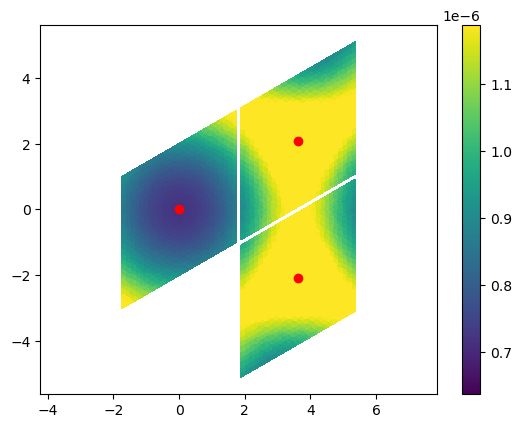

In [449]:
qi=0
s1,s2=0,1
a1,a2=0,0
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.1322219192886696, 5.759820647757106, -5.682792044493537, 5.682792044493537)

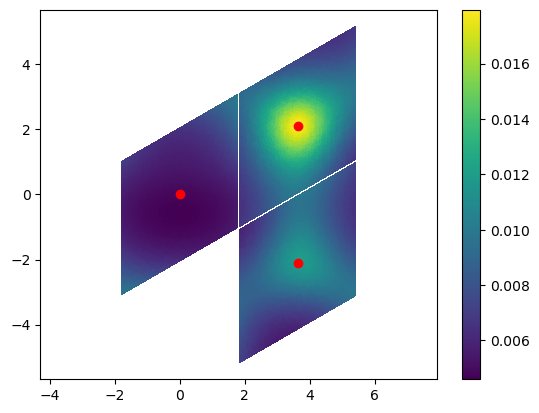

In [403]:
qi=1
s1,s2=0,1
a1,a2=0,0
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

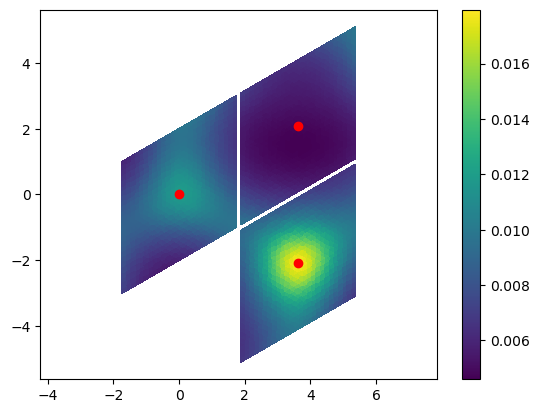

In [400]:
qi=2
s1,s2=1,0
a1,a2=0,0
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [456]:
params=Params(t=[0,-1,-.1],U=[4,0],h=.0,nu=[8,4],n=27)

In [457]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-8)

S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.000 0.000 0.000 1.000 -0.500 -0.500
S2: 0.000 0.000 0.000 0.000 0.866 -0.866
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=8.881784197001252e-16
E(meV):-0.9717745004963225
S0: 0.984 0.984 0.984 1.016 1.016 1.016
S1: 0.031 -0.060 0.030 0.557 -0.278 -0.278
S2: 0.052 -0.000 -0.053 0.000 0.482 -0.482
S3: 0.000 0.000 0.000 -0.000 -0.000 -0.000
Iteration 1:	
Gap(meV)=0.03935187834171128
E(meV):-1.0937099169274975
S0: 1.012 1.012 1.012 0.988 0.988 0.988
S1: 0.051 -0.101 0.051 0.363 -0.182 -0.182
S2: 0.087 -0.000 -0.088 0.000 0.315 -0.315
S3: 0.001 0.000 0.001 -0.000 -0.000 -0.000
Iteration 2:	
Gap(meV)=0.02695532548215107
E(meV):-1.1245555521093438
S0: 0.979 0.979 0.979 1.021 1.021 1.021
S1: 0.057 -0.113 0.057 0.259 -0.130 -0.130
S2: 0.097 -0.000 -0.098 0.000 0.225 -0.224
S3: 0.001 0.001 0.001 -0.001 -0.001 -0.001
Iteration 3:	
Gap(meV)=0.09162689865901985
E(meV):-1.1337583979114574
S0: 1.030 1.031 1.031 0.969 0.969 0.969
S1: 0.05

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

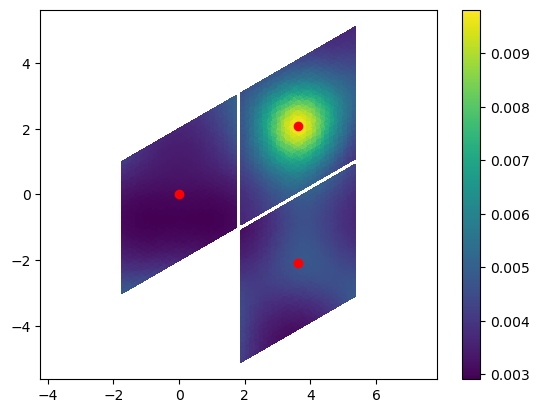

In [455]:
# <c_{q,up,A}^dag c_{q+qi,down,A}> (k), 
# q={Gamma, K, K'}

qi=1
s1,s2=0,1
a1,a2=1,1
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

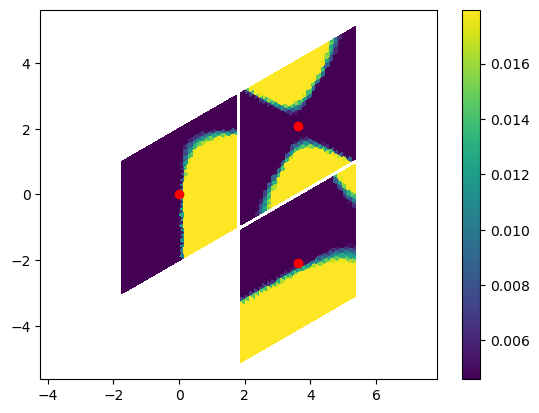

In [445]:
qi=1
s1,s2=0,1
a1,a2=1,1
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

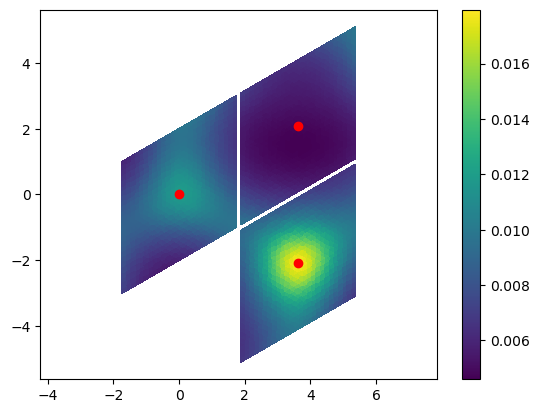

In [446]:
qi=2
s1,s2=1,0
a1,a2=1,1
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

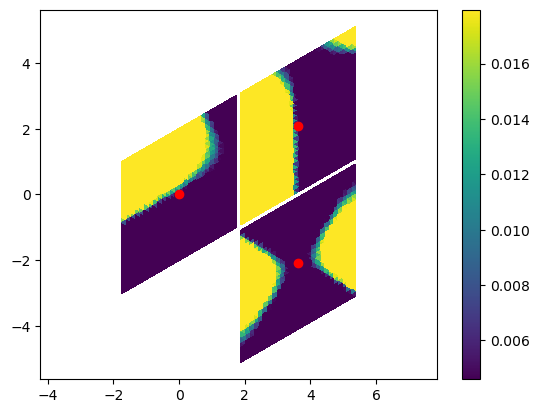

In [447]:
qi=2
s1,s2=1,0
a1,a2=1,1
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [431]:
spin_list[-1,0,1:-1]@spin_list[-1,1,1:-1]/(np.linalg.norm(spin_list[-1,0,1:-1])**2)

-0.5000085565137826

In [399]:
spin_list[-1,2,1:-1]@spin_list[-1,1,1:-1]/(np.linalg.norm(spin_list[-1,0,1:-1])**2)

-0.4999999688536998

In [326]:
spin_list[-1,0,1:-1]@spin_list[-1,2,1:-1]/(np.linalg.norm(spin_list[-1,0,1:-1])**2)

-0.5000000000000017

In [432]:
spin_list[-1,4,1:-1]@spin_list[-1,3,1:-1]/(np.linalg.norm(spin_list[-1,4,1:-1])*np.linalg.norm(spin_list[-1,3,1:-1]))

-0.499978626760217

In [318]:
np.linalg.norm(spin_list[-1,0,1:-1])

0.8398170647860979

In [319]:
np.linalg.norm(spin_list[-1,1,1:-1])

0.8398170647860973

In [320]:
np.linalg.norm(spin_list[-1,2,1:-1])

0.8398170647860974

In [144]:
params=Params(t=[0,-.4,-.2],U=[2,0],h=.1,nu=[6,3],n=27)

In [145]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-8)

S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: -1.00 0.50 0.50 0.00 0.00 0.00
S2: -0.00 -0.87 0.87 0.00 0.00 0.00
S3: 0.00 0.00 0.00 0.00 0.00 0.00
Iteration 0:	
Gap(meV)=0.0
E(meV):-0.32696763161454384
S0: 1.04 1.04 1.04 0.96 0.96 0.96
S1: -0.76 0.38 0.38 -0.03 -0.03 0.06
S2: -0.00 -0.65 0.65 0.05 -0.05 0.00
S3: -0.05 -0.05 -0.05 -0.13 -0.13 -0.13
Iteration 1:	
Gap(meV)=6.58798332642263e-05
E(meV):-0.37500402029361685
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: -0.67 0.34 0.34 -0.08 -0.07 0.15
S2: 0.00 -0.58 0.58 0.13 -0.13 0.00
S3: -0.07 -0.07 -0.07 -0.30 -0.30 -0.30
Iteration 2:	
Gap(meV)=0.000313483386393143
E(meV):-0.41477887481992165
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: -0.66 0.33 0.33 -0.12 -0.12 0.24
S2: 0.00 -0.57 0.57 0.21 -0.21 0.00
S3: -0.06 -0.06 -0.06 -0.48 -0.48 -0.48
Iteration 3:	
Gap(meV)=5.8427938905980525e-05
E(meV):-0.44331659152630154
S0: 0.98 0.98 0.98 1.02 1.02 1.02
S1: -0.68 0.34 0.34 -0.15 -0.15 0.30
S2: 0.00 -0.59 0.59 0.26 -0.26 0.00
S3: -0.03 -0.03 -0.03 -0.62 -0.62 -0.62

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

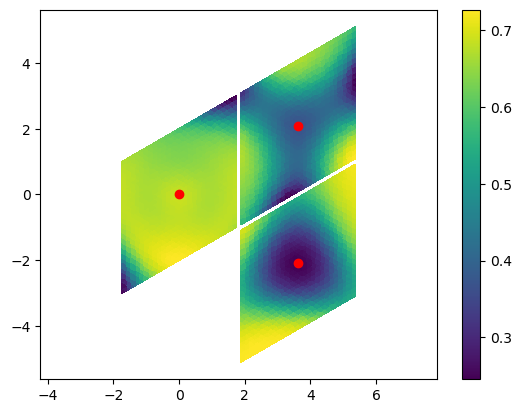

In [147]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,i,0,0,i,0,0].real)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

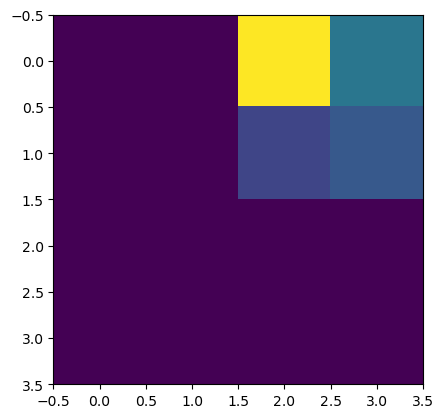

In [152]:
i=2
plt.imshow(np.abs(ave[0,i,:,:,(i+1)%3,:,:].reshape((4,4))))

(-1.921283771003653,
 4.734238443268056,
 -3.3277611071358546,
 3.3277611071358546)

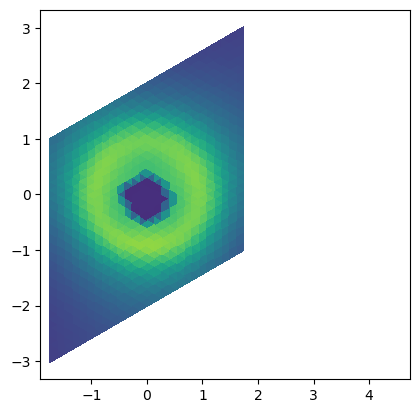

In [143]:
i=0
plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,0,0,(i+1)%3,1,0]),vmin=0,vmax=.4)
plt.axis('square')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

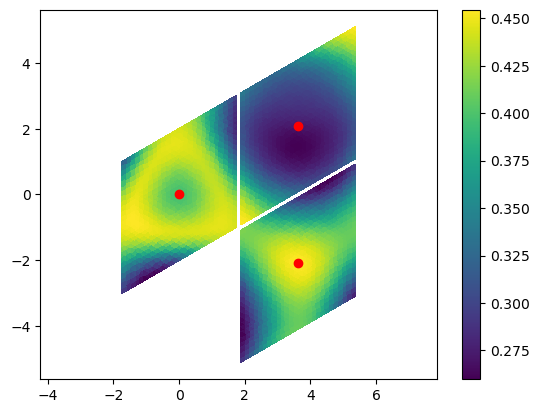

In [155]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[(i+1)%3]).T,np.abs(ave[:,i,0,0,(i+1)%3,1,0]),)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

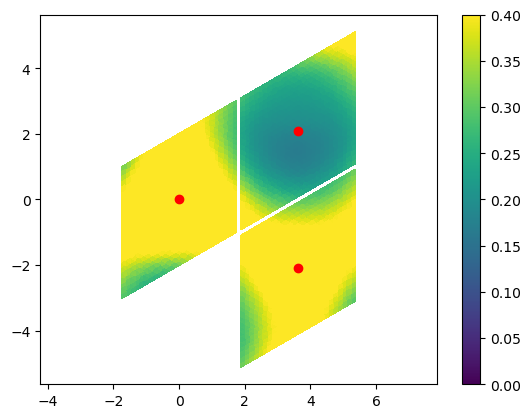

In [153]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,1,0,(i+2)%3,0,0]),vmin=0,vmax=.4)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [ ]:
gap_list,energy_list,spin_list=params.iteration(print_opt='o',thres=1e-8)

S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 1.00 -0.50 -0.50 0.00 0.00 0.00
S2: 0.00 0.87 -0.87 0.00 0.00 0.00
S3: 0.00 0.00 0.00 0.00 0.00 0.00
Iteration 0:	
Gap(meV)=8.881784197001252e-16
E(meV):-0.4310185192876055
S0: 1.02 1.02 1.02 0.98 0.98 0.98
S1: 0.75 -0.38 -0.38 0.04 0.03 -0.07
S2: 0.00 0.65 -0.65 -0.06 0.06 -0.00
S3: -0.05 -0.05 -0.05 -0.40 -0.40 -0.40
Iteration 1:	
Gap(meV)=0.7971310113771284
E(meV):-0.9056862135219325
S0: 0.98 0.98 0.98 1.02 1.02 1.02
S1: 0.80 -0.40 -0.40 0.07 0.06 -0.13
S2: 0.00 0.70 -0.70 -0.11 0.12 -0.00
S3: -0.02 -0.02 -0.02 -0.77 -0.77 -0.77
Iteration 2:	
Gap(meV)=1.7487952730730372
E(meV):-1.0103882236597757
S0: 0.99 0.99 0.99 1.01 1.01 1.01
S1: 0.88 -0.44 -0.44 0.07 0.07 -0.14
S2: 0.00 0.76 -0.76 -0.12 0.13 -0.00
S3: -0.02 -0.02 -0.02 -0.87 -0.87 -0.87
Iteration 3:	
Gap(meV)=2.1935717644722916
E(meV):-1.018629806842282
S0: 0.99 0.99 0.99 1.01 1.01 1.01
S1: 0.90 -0.45 -0.45 0.07 0.07 -0.14
S2: 0.00 0.78 -0.78 -0.12 0.12 -0.00
S3: -0.03 -0.03 -0.03 -0.90 -0.

In [172]:
# params=Params(t=[0,-1,0.],U=[0.1,5],h=0.1,nu=[8,4],n=21)
params=Params(t=[0,-1,0.],U=[1,1],h=0.1,nu=[8,4],n=21)

In [173]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-7)

S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 1.00 -0.50 -0.50 -1.00 0.50 0.50
S2: 0.00 0.00 0.00 0.00 0.00 0.00
S3: 0.00 0.00 0.00 0.00 0.00 0.00
Iteration 0:	
Gap(meV)=0.148839311885689
E(meV):0.33982955773995477
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 0.35 -0.16 -0.21 -0.35 0.21 0.16
S2: 0.00 0.00 -0.00 -0.00 -0.00 -0.00
S3: -0.01 -0.02 -0.02 -0.01 -0.02 -0.02
Iteration 1:	
Gap(meV)=0.06443600541275885
E(meV):0.21728178659387343
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 0.12 -0.05 -0.09 -0.12 0.09 0.05
S2: 0.00 0.00 -0.00 -0.00 -0.00 -0.00
S3: -0.01 -0.01 -0.01 -0.01 -0.01 -0.01
Iteration 2:	
Gap(meV)=0.09520438083411387
E(meV):0.20118263629623714
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 0.04 -0.02 -0.04 -0.04 0.04 0.02
S2: 0.00 0.00 0.00 -0.00 -0.00 -0.00
S3: -0.00 -0.00 -0.00 -0.00 -0.00 -0.00
Iteration 3:	
Gap(meV)=0.12842976957227092
E(meV):0.19899594254455177
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 0.01 -0.01 -0.02 -0.01 0.02 0.01
S2: 0.00 0.00 0.00 -0.00 -0.00 -0.00
S3: -0.00 -0.00 -0.00 -0.00 -

(-2.081550698954507, 5.709149427422943, -5.595026916393249, 5.595026916393249)

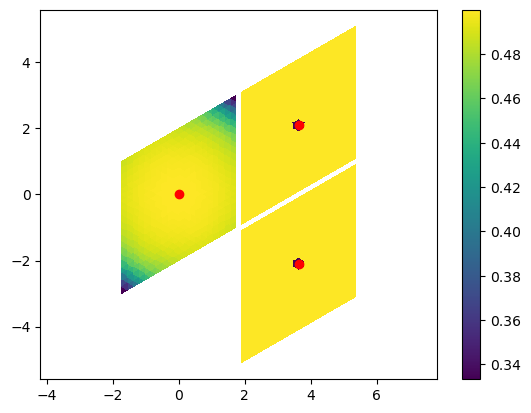

In [174]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,0,0,i,0,0]),)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.081550698954507, 5.709149427422943, -5.595026916393249, 5.595026916393249)

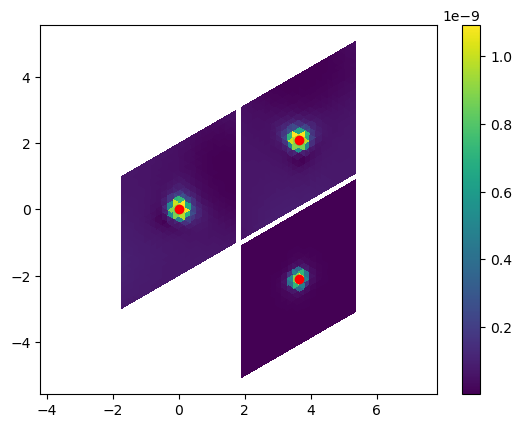

In [175]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,0,0,(i+2)%3,0,0]),)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

Text(0, 0.5, 'Energy')

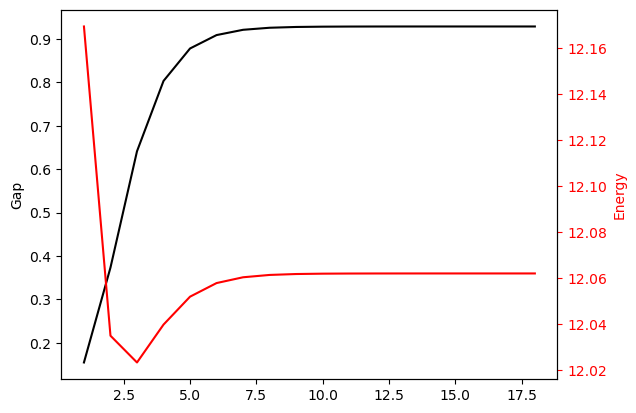

In [113]:
fig,ax=plt.subplots()
ax.plot(gap_list,color='k',label='Gap')
ax.set_ylabel('Gap')
ax2=ax.twinx()
ax2.plot(energy_list,color='r',label='Energy')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel('Energy',color='red')

Text(0, 0.5, '$S_{x,y,z}$')

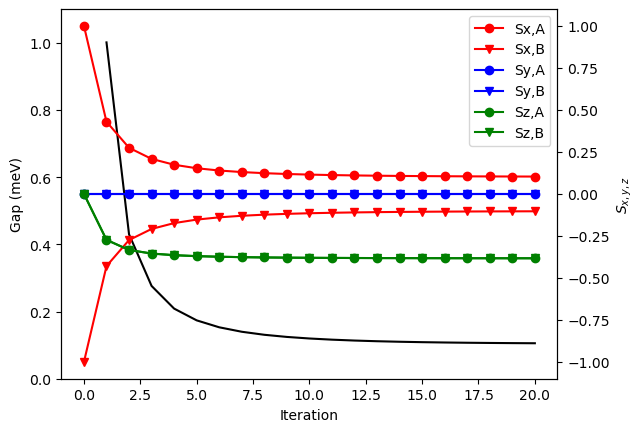

In [514]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k')
ax.set_ylim([0,1.1])
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

Text(0, 0.5, '$S_{x,y,z}$')

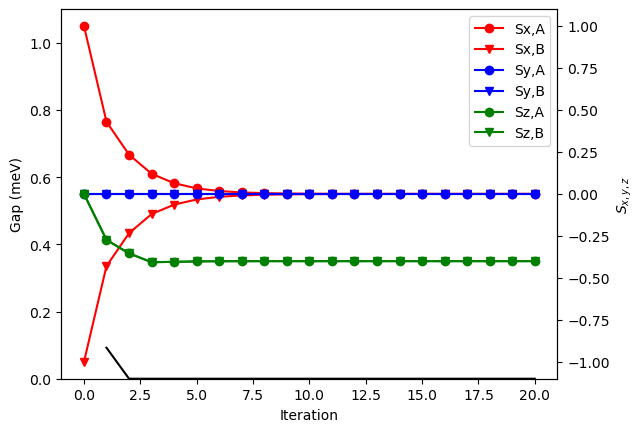

In [524]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k')
ax.set_ylim([0,1.1])
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

Text(0, 0.5, '$S_{x,y,z}$')

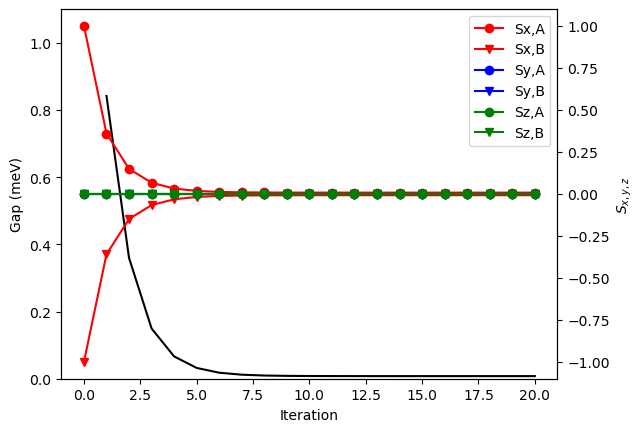

In [521]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k')
ax.set_ylim([0,1.1])
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

In [114]:
energyall[:,0].min(),energyall[:,0].max()

(-2.5413812651491097, 0.0)

In [115]:
energyall[:,1].min(),energyall[:,1].max()

(-2.5413812651491092, 5.551115123125783e-17)

In [116]:
energyall[:,2].min(),energyall[:,2].max()

(1.0, 3.5413812651491092)

In [117]:
energyall[:,3].min(),energyall[:,3].max()

(1.0, 3.5413812651491097)

In [18]:
delta=params._generate_delta()

In [19]:
delta.sum()

27

In [72]:
params_bs=Params(t=[0,-1,-0.4],U=[0,0],h=1,nu=[2,1],n=100)
# energy_list=params_bs.plot_dispersion()

In [73]:
zz=params_bs._ansatz_to_momentum()

In [74]:
energyall,wfall=params_bs.energy_MF(zz)

(-4.350455015302128, 12.350455015302128, -6.84238879951857, 6.84238879951857)

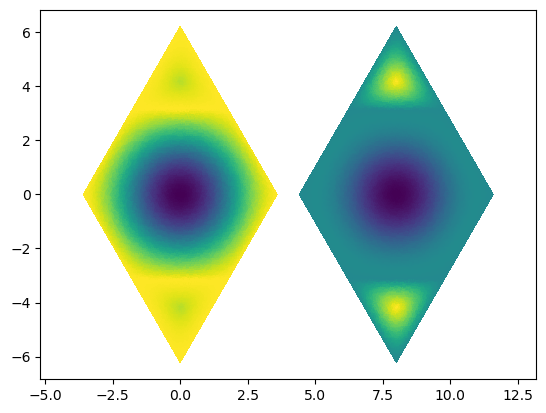

In [76]:
plt.tripcolor(*(params_bs.k).T,energyall[:,1],)
plt.tripcolor(*(params_bs.k+np.array([8,0])).T,energyall[:,2],)

plt.axis('equal')

In [ ]:
gap_list,energy_list,spin_list,ave=params_bs.iteration(print_opt='o',thres=1e-5)

In [ ]:
params_bs.high_symm['G_M_K_G'].shape

(46, 2)

In [ ]:
params_bs.high_symm['G_M_K_G_dist'].shape

(64,)

ValueError: x and y must have same first dimension, but have shapes (46,) and (82, 12)

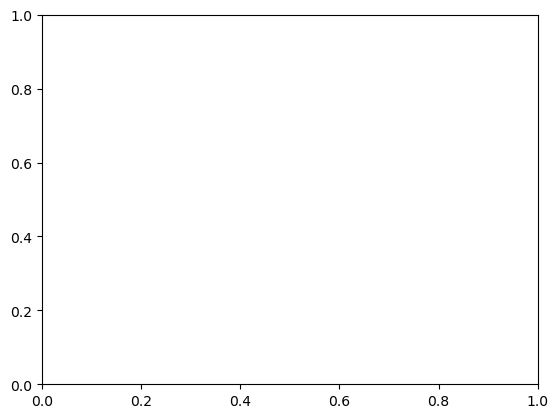

In [ ]:
energy_list.shape

(15,)

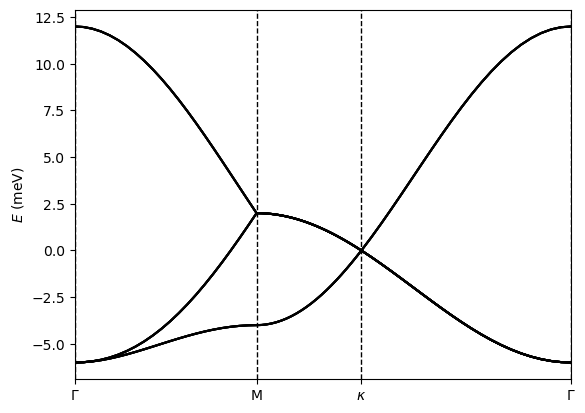

In [ ]:
energy_list=params.plot_dispersion(k=20)

In [ ]:
(energy_list[:,0].max()-energy_list[:,0].min())/(energy_list[:,-1].max()-energy_list[:,-1].min())

1.8571428571428577

In [ ]:
T=params._generate_T(params.k)

In [ ]:
T=params._generate_T(params.high_symm['G_M_K_G'])

In [ ]:
energyall,wfall=params._eig(T)

In [ ]:
energyall.shape

(729, 12)

In [ ]:
np.prod(energyall.shape)

8748

In [ ]:
params.q.shape[0]*params.k.shape[0]*2

4374

In [ ]:
energyall[:,0].min(),energyall[:,0].max()

(-4.0, -1.0000000000000013)

In [ ]:
energyall[:,1].min(),energyall[:,1].max()

(-2.0, -0.022094269184347315)

In [ ]:
energyall[:,2].min(),energyall[:,2].max()

(0.022094269184347315, 2.0)

In [ ]:
energyall[:,3].min(),energyall[:,3].max()

(1.0000000000000013, 4.0)

In [ ]:
energyall[441//2]

array([-3., -3.,  3.,  3.])

In [ ]:
params.k[441//2]

array([0., 0.])

In [ ]:
np.abs((T.transpose((1,0,2))).conj()-T).max()

4.440892098500626e-16

In [ ]:
params.q.shape[0]

3

In [ ]:
for q in params.q:
    print(q)

[0. 0.]
[3.62759873 2.0943951 ]
[ 3.62759873 -2.0943951 ]


In [ ]:
params.neighbor_list

{0: [array([ 0., -0.])],
 1: [array([-0.57735027, -0.        ]),
  array([ 0.28867513, -0.5       ]),
  array([0.28867513, 0.5       ])],
 2: [array([ 0.8660254, -0.5      ]),
  array([0.8660254, 0.5      ]),
  array([0., 1.]),
  array([-0.8660254,  0.5      ]),
  array([-0.8660254, -0.5      ]),
  array([ 0., -1.])]}

In [ ]:
params.am

array([[ 1.73205081,  0.        ],
       [ 0.8660254 , -1.5       ]])

In [ ]:
params.bm

array([[-1.81379936e+00, -1.04719755e+00],
       [ 4.04528380e-17,  2.09439510e+00]])

In [ ]:
params.bM

array([[ 3.62759873, -6.28318531],
       [ 3.62759873,  6.28318531]])

(-3.99035860131528, 9.83264907447981, -6.911503837897545, 6.911503837897545)

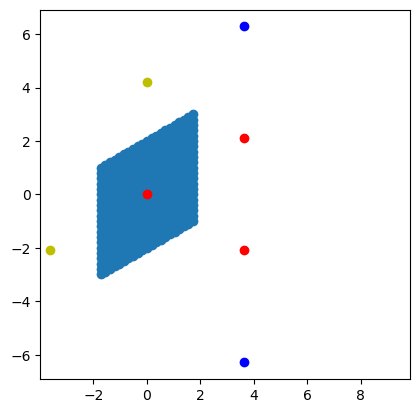

In [ ]:
plt.scatter(*params.k.T)
plt.scatter(*params.q.T,color='r')
plt.scatter(*params.bM.T,color='b')
plt.scatter(*params.bm.T,color='y')
plt.axis('square')

In [ ]:
params.am_index

array([[ 1,  1],
       [ 2, -1]])

In [ ]:
params.bm_index

array([[-0.33333333, -0.66666667],
       [-0.33333333,  0.33333333]])

In [ ]:
params.am.T@params.bm

array([[-3.14159265e+00, -5.77375316e-17],
       [-6.06792571e-17, -3.14159265e+00]])

In [ ]:
a = np.arange(60.).reshape(3,4,5)
b = np.arange(24.).reshape(4,3,2)

In [ ]:
c=np.tensordot(a, b,axes=([0],[1]))

In [ ]:
c.shape

(4, 5, 4, 2)

# Direct input order parameter

## intra s

In [57]:
# params=Params(t=[0,-1,0],U=[2,0],h=.3,nu=[12,6],n=9)
params=Params(t=[0,-1,0],U=[2,0],h=.3,nu=[12,6],n=9)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 0.000 0.000 0.000 0.000 0.000 0.000
S1: 0.768 0.768 0.768 -0.768 -0.768 -0.768
S2: 0.000 0.000 0.000 0.000 0.000 0.000
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=1.5437360840452645
E(meV):-2.0810082926304
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.496 0.496 0.496 -0.496 -0.496 -0.496
S2: 0.000 0.000 0.000 0.000 0.000 0.000
S3: -0.068 -0.068 -0.068 -0.068 -0.068 -0.068
Iteration 1:	
Gap(meV)=0.9919005106882297
E(meV):-2.1282207203088848
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.373 0.373 0.373 -0.373 -0.373 -0.373
S2: -0.000 -0.000 -0.000 0.000 0.000 0.000
S3: -0.067 -0.067 -0.067 -0.067 -0.067 -0.067
Iteration 2:	
Gap(meV)=0.7461323945548035
E(meV):-2.1417651428684814
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.303 0.303 0.303 -0.303 -0.303 -0.303
S2: 0.000 0.000 0.000 -0.000 -0.000 -0.000
S3: -0.056 -0.056 -0.056 -0.056 -0.056 -0.056
Iteration 3:	
Gap(meV)=0.6060751481367292
E(meV):-2.147257669908257
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.257 0.

In [58]:
spin_mat=params._generate_spin_mat(ave)

In [59]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,0.1169+0.0000j,-0.0256+0.0000j,-0.0058-0.0000j,-0.0000-0.0000j,0.0000+0.0000j,0.0000+0.0000j
A2,-0.0256-0.0000j,0.1169+0.0000j,-0.0256+0.0000j,-0.0000+0.0000j,-0.0000-0.0000j,0.0000+0.0000j
A3,-0.0058+0.0000j,-0.0256-0.0000j,0.1169+0.0000j,0.0000+0.0000j,-0.0000+0.0000j,-0.0000-0.0000j
B1,-0.0000+0.0000j,-0.0000-0.0000j,0.0000-0.0000j,-0.1169+0.0000j,0.0256-0.0000j,0.0058+0.0000j
B2,0.0000-0.0000j,-0.0000+0.0000j,-0.0000-0.0000j,0.0256+0.0000j,-0.1169+0.0000j,0.0256-0.0000j
B3,0.0000-0.0000j,0.0000-0.0000j,-0.0000+0.0000j,0.0058-0.0000j,0.0256+0.0000j,-0.1169+0.0000j


(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

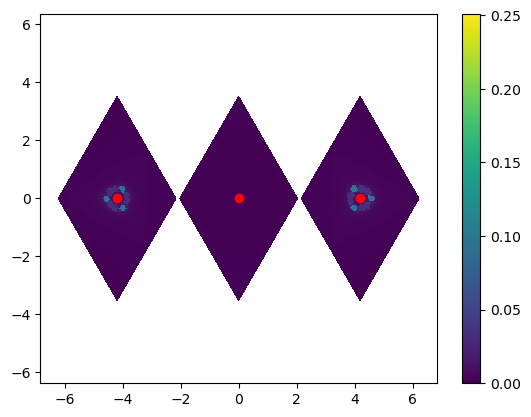

In [192]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+0)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

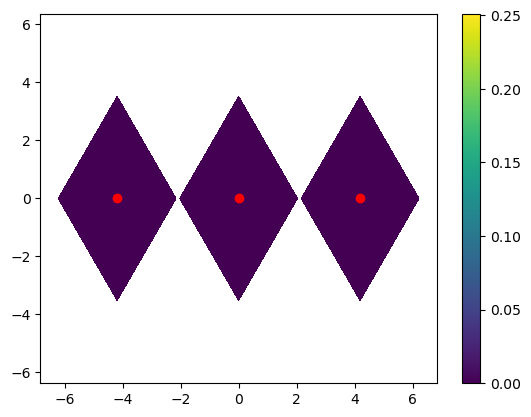

In [193]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+1)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

## inter s

In [3]:
params=Params(t=[0,-1,0],U=[0,3],h=.3,nu=[14,7],n=15)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 0.000 0.000 0.000 0.000 0.000 0.000
S1: 0.000 0.000 0.000 0.000 0.000 0.000
S2: 0.000 0.000 -0.000 -0.000 0.000 -0.000
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=0.044437235746921704
E(meV):6.227006126781206
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.000 0.000 0.000 0.000 0.000 0.000
S2: 0.000 -0.000 -0.000 0.000 -0.000 0.000
S3: -0.101 -0.069 -0.069 -0.101 -0.069 -0.069
Iteration 1:	
Gap(meV)=0.16113934328478408
E(meV):4.89291188125336
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: -0.000 -0.000 -0.000 -0.000 0.000 0.000
S2: -0.000 -0.000 0.000 -0.000 0.000 0.000
S3: -0.064 -0.040 -0.040 -0.064 -0.040 -0.040
Iteration 2:	
Gap(meV)=0.018539868005509774
E(meV):3.60502932482936
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.000 -0.000 -0.000 -0.000 0.000 0.000
S2: -0.000 0.000 -0.000 0.000 -0.000 -0.000
S3: -0.038 -0.021 -0.021 -0.038 -0.021 -0.021
Iteration 3:	
Gap(meV)=0.05310667703387928
E(meV):2.8693365503474424
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.000

In [233]:
np.where((params.delta_exp1234[0,0])==3)

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]),
 array([0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2]),
 array([0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))

In [4]:
spin_mat=params._generate_spin_mat(ave)

In [5]:
ave.max()

(0.500000000121242-7.822496050333258e-27j)

In [6]:
ave[:,:,0,:,:,1,:].max()

(5.668677457492816e-08-1.1151467679509914e-07j)

In [7]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),6),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,0.000000+0.000000j,-0.000000+0.000000j,0.000000-0.000000j,-0.000001+0.000000j,0.000001-0.000000j,-0.000000-0.000000j
A2,-0.000000-0.000000j,-0.000000-0.000000j,0.000000+0.000000j,-0.000001-0.000000j,0.000000-0.000000j,-0.000001-0.000000j
A3,0.000000+0.000000j,0.000000-0.000000j,-0.000000+0.000000j,-0.000000+0.000000j,0.000001-0.000000j,0.000000-0.000000j
B1,-0.000001-0.000000j,-0.000001+0.000000j,-0.000000-0.000000j,-0.000000+0.000000j,0.000000-0.000000j,0.000000-0.000000j
B2,0.000001+0.000000j,0.000000+0.000000j,0.000001+0.000000j,0.000000+0.000000j,-0.000000-0.000000j,-0.000000-0.000000j
B3,-0.000000+0.000000j,-0.000001+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.000000+0.000000j,0.000000-0.000000j


In [246]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,-0.0+0.0j,0.0+0.0j,-0.0-0.0j,-0.0-0.0j,-0.0+0.0j,0.0-0.0j
A2,0.0-0.0j,0.0-0.0j,-0.0-0.0j,0.0+0.0j,0.0-0.0j,-0.0+0.0j
A3,-0.0+0.0j,-0.0+0.0j,-0.0+0.0j,-0.0-0.0j,0.0+0.0j,0.0-0.0j
B1,-0.0+0.0j,0.0-0.0j,-0.0+0.0j,-0.0+0.0j,0.0+0.0j,0.0-0.0j
B2,-0.0-0.0j,0.0+0.0j,0.0-0.0j,0.0-0.0j,0.0-0.0j,-0.0+0.0j
B3,0.0+0.0j,-0.0-0.0j,0.0+0.0j,0.0+0.0j,-0.0-0.0j,0.0+0.0j


(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

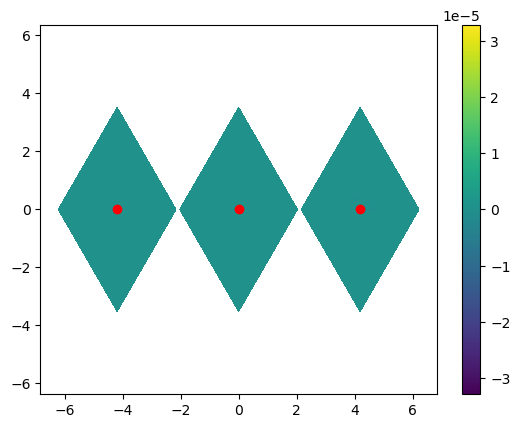

In [200]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+0)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

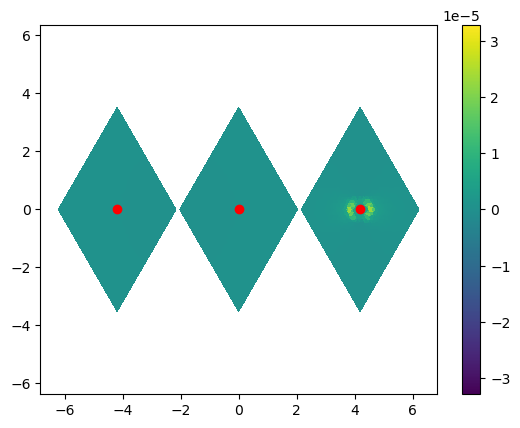

In [201]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+1)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [202]:
spin_mat=params._generate_spin_mat(ave)

In [203]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),3),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,0.0+0.0j,-0.0+0.0j,-0.0-0.0j,0.0+0.0j,0.0+0.0j,-0.0+0.0j
A2,-0.0-0.0j,0.0-0.0j,-0.0+0.0j,-0.0-0.0j,0.0+0.0j,0.0-0.0j
A3,-0.0+0.0j,-0.0-0.0j,0.0-0.0j,0.0-0.0j,-0.0+0.0j,0.0+0.0j
B1,0.0-0.0j,-0.0+0.0j,0.0+0.0j,-0.0-0.0j,0.0-0.0j,0.0+0.0j
B2,0.0-0.0j,0.0-0.0j,-0.0-0.0j,0.0+0.0j,-0.0+0.0j,0.0-0.0j
B3,-0.0-0.0j,0.0+0.0j,0.0-0.0j,0.0-0.0j,0.0+0.0j,-0.0+0.0j


In [204]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),3),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,-0.0+0.0j,-0.0+0.0j,0.0-0.0j,-0.0+0.0j,0.0+0.0j,-0.0-0.0j
A2,-0.0-0.0j,0.0-0.0j,0.0+0.0j,-0.0-0.0j,-0.0+0.0j,0.0+0.0j
A3,0.0+0.0j,0.0-0.0j,-0.0+0.0j,0.0-0.0j,-0.0-0.0j,-0.0+0.0j
B1,-0.0-0.0j,-0.0+0.0j,0.0+0.0j,0.0+0.0j,-0.0-0.0j,0.0+0.0j
B2,0.0-0.0j,-0.0-0.0j,-0.0+0.0j,-0.0+0.0j,0.0+0.0j,-0.0-0.0j
B3,-0.0+0.0j,0.0-0.0j,-0.0-0.0j,0.0-0.0j,-0.0+0.0j,-0.0-0.0j


## intra p

In [39]:
params=Params(t=[0,-1,0],U=[0,1],h=.4,nu=[16,8],n=15)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 0.000 0.000 0.000 0.000 0.000 0.000
S1: 0.000 0.000 0.000 -0.000 -0.000 -0.000
S2: -0.000 -0.000 -0.000 0.000 0.000 0.000
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=0.26828606549009265
E(meV):-0.3855740037197536
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: -0.000 -0.000 -0.000 0.000 0.000 0.000
S2: -0.000 -0.000 -0.000 0.000 0.000 0.000
S3: -0.090 -0.090 -0.090 -0.090 -0.090 -0.090
Iteration 1:	
Gap(meV)=0.16858386394604663
E(meV):-0.6883104236860229
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: -0.000 -0.000 -0.000 0.000 0.000 0.000
S2: -0.000 -0.000 -0.000 0.000 0.000 0.000
S3: -0.035 -0.035 -0.035 -0.035 -0.035 -0.035
Iteration 2:	
Gap(meV)=0.05805139267778392
E(meV):-0.7307191735034022
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.000 0.000 0.000 -0.000 -0.000 -0.000
S2: 0.000 0.000 0.000 -0.000 -0.000 -0.000
S3: -0.031 -0.031 -0.031 -0.031 -0.031 -0.031
Iteration 3:	
Gap(meV)=0.0706208026724946
E(meV):-0.7370926256275666
S0: 1.000 1.000 1.000 1.000 1.000 1.000

In [40]:
spin_mat=params._generate_spin_mat(ave)

In [41]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),10),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,-0.000000+0.000000j,0.000000+0.000198j,0.000000-0.000108j,-0.000646+0.000000j,0.000449+0.000000j,-0.000025-0.000000j
A2,0.000000-0.000198j,-0.000000+0.000000j,0.000000+0.000198j,0.000495-0.000000j,-0.000646+0.000000j,0.000449+0.000000j
A3,0.000000+0.000108j,0.000000-0.000198j,-0.000000+0.000000j,-0.000144+0.000000j,0.000495-0.000000j,-0.000646+0.000000j
B1,-0.000646-0.000000j,0.000495+0.000000j,-0.000144-0.000000j,0.000000+0.000000j,-0.000000-0.000198j,-0.000000+0.000108j
B2,0.000449-0.000000j,-0.000646-0.000000j,0.000495+0.000000j,-0.000000+0.000198j,0.000000+0.000000j,-0.000000-0.000198j
B3,-0.000025+0.000000j,0.000449-0.000000j,-0.000646-0.000000j,-0.000000-0.000108j,-0.000000+0.000198j,0.000000+0.000000j


In [42]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),10),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,-0.000000+0.000000j,-0.000000+0.000101j,0.000000-0.000049j,0.000000-0.000000j,-0.000276+0.000000j,0.000052+0.000000j
A2,-0.000000-0.000101j,-0.000000+0.000000j,-0.000000+0.000101j,0.000454+0.000000j,0.000000-0.000000j,-0.000276+0.000000j
A3,0.000000+0.000049j,-0.000000-0.000101j,-0.000000+0.000000j,-0.000298+0.000000j,0.000454+0.000000j,0.000000-0.000000j
B1,0.000000+0.000000j,0.000454-0.000000j,-0.000298-0.000000j,0.000000-0.000000j,0.000000-0.000101j,-0.000000+0.000049j
B2,-0.000276-0.000000j,0.000000+0.000000j,0.000454-0.000000j,0.000000+0.000101j,0.000000-0.000000j,0.000000-0.000101j
B3,0.000052-0.000000j,-0.000276-0.000000j,0.000000+0.000000j,-0.000000-0.000049j,0.000000+0.000101j,0.000000-0.000000j


(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

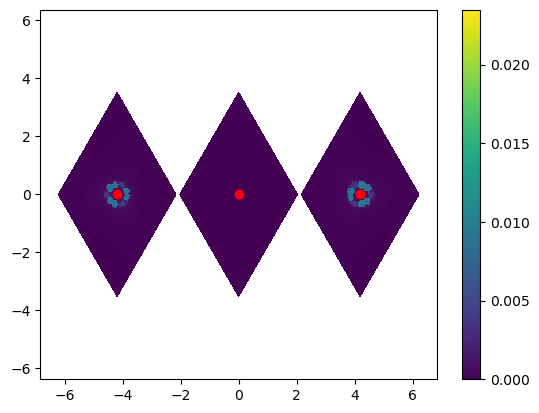

In [209]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+0)%3,s1,a1,i,s2,a2].__abs__(),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

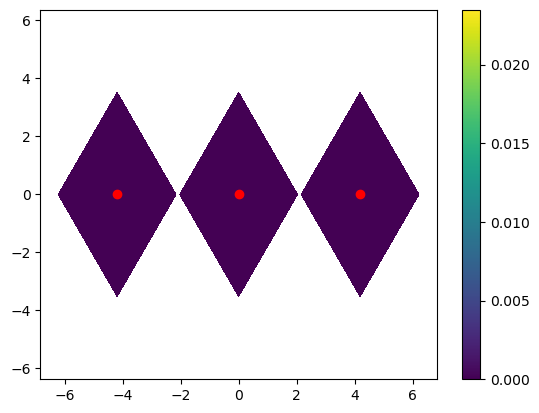

In [210]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+1)%3,s1,a1,i,s2,a2].__abs__(),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

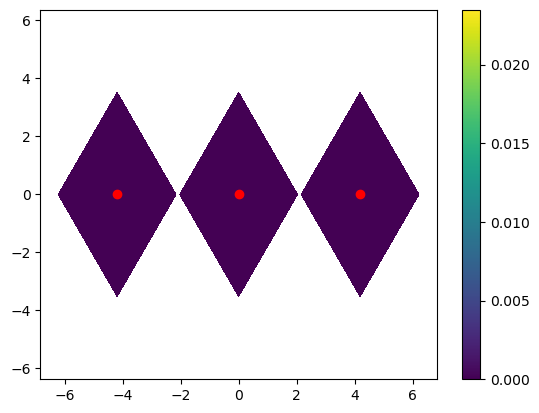

In [211]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+0)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [287]:
spin_mat=params._generate_spin_mat(ave)

In [289]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),10),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

,A1,A2,A3,B1,B2,B3
A1,0.000000-0.000000j,-0.000000e+00-0.000000e+00j,-0.000000+0.000000j,0.000000e+00-0.000000e+00j,-0.000000+0.000003j,0.000000+0.000002j
A2,-0.000000+0.000000j,0.000000e+00+0.000000e+00j,-0.000000-0.000000j,-0.000000e+00-6.202000e-07j,0.000000-0.000000j,-0.000000-0.000006j
A3,-0.000000-0.000000j,-0.000000e+00+0.000000e+00j,0.000000+0.000000j,-0.000000e+00-1.144700e-06j,0.000000+0.000001j,-0.000000-0.000000j
B1,0.000000+0.000000j,-0.000000e+00+6.202000e-07j,-0.000000+0.000001j,-0.000000e+00+0.000000e+00j,0.000000+0.000000j,0.000000-0.000000j
B2,-0.000000-0.000003j,0.000000e+00+0.000000e+00j,0.000000-0.000001j,0.000000e+00-0.000000e+00j,-0.000000-0.000000j,-0.000000+0.000000j
B3,0.000000-0.000002j,-0.000000e+00+5.953300e-06j,-0.000000+0.000000j,0.000000e+00+0.000000e+00j,-0.000000-0.000000j,-0.000000-0.000000j


did not find intervalley, will converge to AF

In [286]:

params=Params(t=[0,-1,0],U=[0,3],h=.1,nu=[14,7],n=27)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 0.000 0.000 0.000 0.000 0.000 0.000
S1: 0.000 0.000 0.000 0.000 0.000 0.000
S2: -0.000 0.001 -0.001 0.000 0.001 -0.001
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=0.06242736358454901
E(meV):4.611037562454529
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: -0.000 -0.000 -0.000 -0.000 0.000 0.000
S2: -0.000 0.000 -0.000 -0.000 0.000 -0.000
S3: -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
Iteration 1:	
Gap(meV)=0.06242745490212975
E(meV):4.611036914178972
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: -0.000 0.000 0.000 -0.000 -0.000 0.000
S2: 0.000 0.000 -0.000 -0.000 0.000 -0.000
S3: -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
Iteration 2:	
Gap(meV)=0.06242748595679792
E(meV):4.6110366938879395
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.000 0.000 0.000 -0.000 -0.000 -0.000
S2: 0.000 0.000 -0.000 -0.000 0.000 -0.000
S3: -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
Iteration 3:	
Gap(meV)=0.06242749651236501
E(meV):4.611036619030018
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.

(-6.801797427772184, 6.801797427772184, -3.800341525062173, 3.800341525062173)

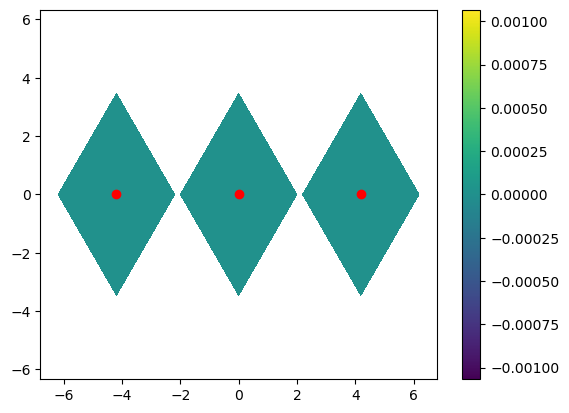

In [276]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+0)%3,s1,a1,i,s2,a2].__abs__(),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.801797427772184, 6.801797427772184, -3.800341525062173, 3.800341525062173)

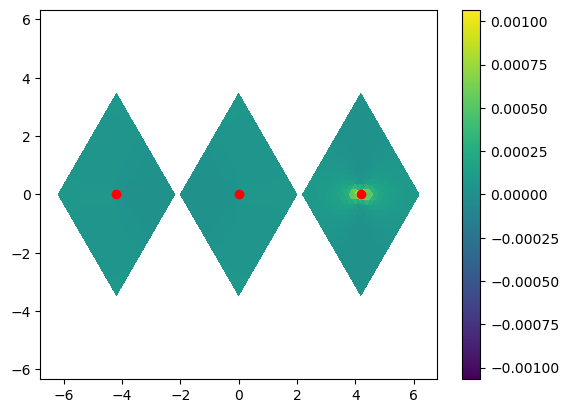

In [277]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+1)%3,s1,a1,i,s2,a2].__abs__(),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.801797427772184, 6.801797427772184, -3.800341525062173, 3.800341525062173)

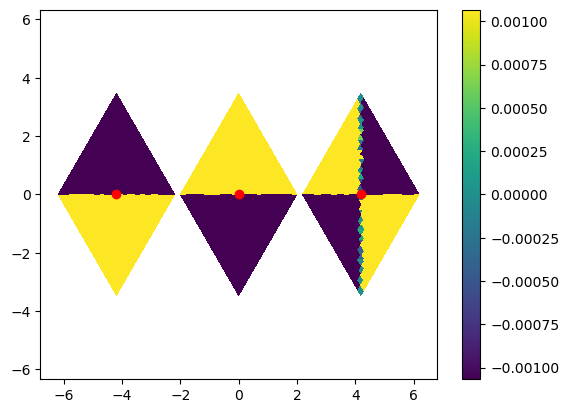

In [278]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+1)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

# Obs

In [ ]:
    # def _ansatz_to_momentum(self):
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     cc=np.zeros((Nq,2,2,2,2),dtype=complex) # a,s1,s2,alpha1,alpha2
    #     for ai_idx,ai in enumerate(self.ai_index):
    #         ccA=1/2*(self.sigma[0]+self.spinA0[ai_idx][0]*self.sigma[1]+self.spinA0[ai_idx][1]*self.sigma[2]+self.spinA0[ai_idx][2]*self.sigma[3]).conj()
    #         ccB=1/2*(self.sigma[0]+self.spinB0[ai_idx][0]*self.sigma[1]+self.spinB0[ai_idx][1]*self.sigma[2]+self.spinB0[ai_idx][2]*self.sigma[3]).conj()
    #         cc[ai_idx,:,:,0,0]=ccA
    #         cc[ai_idx,:,:,1,1]=ccB
            
    #     ai_x,q1_x,q2_x=np.meshgrid(self.ai_index[:,0],self.q[:,0],self.q[:,0],indexing='ij')
    #     ai_y,q1_y,q2_y=np.meshgrid(self.ai_index[:,1],self.q[:,1],self.q[:,1],indexing='ij')
    #     exp=np.exp(1j*((q1_x-q2_x)*ai_x+(q1_y-q2_y)*ai_y)) # a,q1,q2

    #     ave=np.tensordot(exp, cc,axes=([0],[0])) # q1,q2,s1,s2,alpha1,alpha2
    #     ave=np.tile(ave[:,:,:,:,:,:,np.newaxis],[1,1,1,1,1,1,Nk])/Nq # q1,q2,s1,s2,alpha1,alpha2, k
    #     ave=np.transpose(ave,axes=(6,0,2,4,1,3,5))
    #     return ave

# def _generate_Hartree(self,ave):
    #     '''
    #     ave q3,q4,s1,s2,alpha1,alpha2,k'
    #     '''
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     N=Nq*Nk

    #     ave=np.transpose(ave,axes=(1,4,2,5,3,6,0)) #q3,q4,s1,s2,alpha1,alpha2,k'
            
    #     ave_k=np.sum(ave,axis=-1)   #q3,q4,s1,s2,alpha1,alpha2
    #     delta_ave=np.tensordot(self.delta, ave_k,axes=([2,3],[0,1]))  # q1,q2,s1,s2,alpha1,alpha2
    #     H_H_0=np.kron(delta_ave[:,:,1,1,0,0],self.o[0,0])\
    #          +np.kron(delta_ave[:,:,1,1,1,1],self.o[1,1])\
    #          +np.kron(delta_ave[:,:,0,0,0,0],self.o[2,2])\
    #          +np.kron(delta_ave[:,:,0,0,1,1],self.o[3,3])
    #     H_H_0=H_H_0*self.U[0]/N

    #     delta_ave_s=delta_ave.trace(axis1=2,axis2=3) #q1,q2,alpha1,alpha2
    #     H_H_1=np.kron(delta_ave_s[:,:,1,1],self.o[0,0])\
    #          +np.kron(delta_ave_s[:,:,0,0],self.o[1,1])\
    #          +np.kron(delta_ave_s[:,:,1,1],self.o[2,2])\
    #          +np.kron(delta_ave_s[:,:,0,0],self.o[3,3])

    #     H_H_1=H_H_1*self.U[1]/N
    #     H_H=H_H_0+H_H_1
    #     return np.tile(H_H[:,:,np.newaxis],[1,1,Nk])
        

        # def _generate_Fock(self,ave):
    #     '''
    #     ave q3,q4,s1,s2,alpha1,alpha2,k'
    #     '''
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     N=Nq*Nk
    #     ave_k=np.sum(ave,axis=-1) # q3,q4,s1,s2,alpha1,alpha2
    #     delta_ave=np.tensordot(self.delta,ave_k,axes=([2,3],[0,1])) # q1,q2,s1,s2,alpha_1,alpha_2 Duplicated with Hartree
    #     H_F_0=np.kron(delta_ave[:,:,1,0,0,0],self.o[0,2])+\
    #           np.kron(delta_ave[:,:,0,1,0,0],self.o[2,0])+\
    #           np.kron(delta_ave[:,:,1,0,1,1],self.o[1,3])+\
    #           np.kron(delta_ave[:,:,0,1,1,1],self.o[3,1])

    #     H_F_0=-H_F_0*self.U[0]/N

    #     H_F_1=np.kron(delta_ave[:,:,0,0,1,0],self.o[0,1])+\
    #           np.kron(delta_ave[:,:,1,0,1,0],self.o[0,3])+\
    #           np.kron(delta_ave[:,:,0,0,0,1],self.o[1,0])+\
    #           np.kron(delta_ave[:,:,1,0,0,1],self.o[1,2])+\
    #           np.kron(delta_ave[:,:,0,1,1,0],self.o[2,1])+\
    #           np.kron(delta_ave[:,:,1,1,1,0],self.o[2,3])+\
    #           np.kron(delta_ave[:,:,0,1,0,1],self.o[3,0])+\
    #           np.kron(delta_ave[:,:,1,1,0,1],self.o[3,2])

    #     H_F_1=-H_F_1*self.U[1]/N

    #     H_F=H_F_0+H_F_1

    #     return np.tile(H_F[:,:,np.newaxis],[1,1,Nk])

        # def _average_old(self,energyall,wfall):
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     N=Nq*Nk
    #     energyall_sort=np.sort(energyall.flatten())
    #     mu=energyall_sort[Nq*Nk*self.nu[0]//self.nu[1]-1] # !!Need check
    #     occ=(energyall<=mu)  # k,l
    #     c=wfall.reshape((Nk,4*Nq,Nq,2,2))   # c_{k,l,q,s,alpha} !!Need check -> checked
    #     c_conj=c.conj() 
    #     occ_c=np.tile(occ[:,:,np.newaxis,np.newaxis,np.newaxis],(1,1,Nq,2,2))*c # {k,l,q,s,alpha}
    #     ave=np.zeros((Nk,Nq,2,2,Nq,2,2),dtype=complex) # k,q1,s1,alpha1,q2,s2,alpha2
    #     for k_idx in range(Nk):
    #         ave[k_idx]=np.tensordot(c_conj[k_idx],occ_c[k_idx],axes=([0],[0])) 
    #     # ave=np.tensordot(c_conj,occ_c,axes=([1],[1])) # k,q1,s1,alpha1,q2,s2,alpha2
    #     # ave=np.transpose(ave,axes=(1,4,2,5,3,6,0)) # q1,q2,s1,s2,alpha1,alpha2,k
    #     return ave



    # def print_spin(self,ave):
    #     '''
    #     ave q1,q2,s1,s2,alpha1,alpha2,k
    #     '''
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     N=Nq*Nk
    #     ai_x,q1_x,q2_x=np.meshgrid(self.ai_index[:,0],self.q[:,0],self.q[:,0],indexing='ij')
    #     ai_y,q1_y,q2_y=np.meshgrid(self.ai_index[:,1],self.q[:,1],self.q[:,1],indexing='ij')
    #     exp=np.exp(-1j*(ai_x*(q1_x-q2_x)+ai_y*(q1_y-q2_y))) # ai, q1,q2
    #     ave_k=np.sum(ave,axis=-1) # q1,q2,s1,s2,alpha1,alpha2,
    #     ave_alpha_k=np.zeros((Nq,Nq,2,2,2),dtype=complex) # q1,q2,s1,s2,alpha
    #     for i in range(2):
    #         ave_alpha_k[:,:,:,:,i]=ave_k[:,:,:,:,i,i]
    #     S=np.zeros((Nq*2,4)) # (A,a1), (A,a2).. (B,a1), (B,a2)..
    #     for sigma_idx,sigma in enumerate(self.sigma):
    #         # sigma s1, s2
    #         ave_sigma=np.tensordot(ave_alpha_k,sigma,axes=([2,3],[0,1])) #q1,q2,alpha
    #         ave_exp=np.tensordot(ave_sigma, exp,axes=([0,1],[1,2]))/N # alpha, a
    #         assert np.abs(ave_exp.imag).max()<1e-10, f"spin is not real for {sigmax_idx} with {ave_exp}"
    #         S[:,sigma_idx]=ave_exp.real.flatten()
    #     print(S)
    #     return S